In [989]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
import folium
import requests
from datetime import timedelta
from plotly.subplots import make_subplots
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.svm import SVR
from statsmodels.tsa.api import Holt,SimpleExpSmoothing,ExponentialSmoothing
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.preprocessing import PolynomialFeatures
from pmdarima import auto_arima
from statsmodels.tsa.arima_model import ARIMA
from IPython.core.display import HTML
# from fbprophet import Prophet

In [1134]:
df_covid19 = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/web-data/data/cases_country.csv")

In [1135]:
df_covid19 = df_covid19.drop(["People_Tested","People_Hospitalized","UID","ISO3","Mortality_Rate"],axis =1)
df_covid19.head(2)

,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Incident_Rate
0,Australia,2020-06-02 01:33:03,-25.000000,133.000000,7221.000000,102.000000,6626.000000,493.000000,28.362471
1,Austria,2020-06-02 01:33:03,47.516200,14.550100,16733.000000,668.000000,15596.000000,469.000000,185.790105


In [1136]:
india_data_json = requests.get('https://api.rootnet.in/covid19-in/unofficial/covid19india.org/statewise').json()
df_india = pd.io.json.json_normalize(india_data_json['data']['statewise'])
df_india = df_india.set_index("state")

In [1137]:
total = df_india.sum()
total.name = "Total"
df_t = pd.DataFrame(total,dtype=float).transpose()
df_t["Mortality Rate (per 100)"] = np.round(100*df_t["deaths"]/df_t["confirmed"],2)
df_t.style.background_gradient(cmap='Oranges',axis=1)

,confirmed,recovered,deaths,active,Mortality Rate (per 100)
Total,198370,95754,5608,96997,2.83


In [947]:
df_india["Mortality Rate (per 100)"]= np.round(np.nan_to_num(100*df_india["deaths"]/df_india["confirmed"]),2)
df_india.style.background_gradient(cmap='Blues',subset=["confirmed"])\
                        .background_gradient(cmap='Reds',subset=["deaths"])\
                        .background_gradient(cmap='Greens',subset=["recovered"])\
                        .background_gradient(cmap='Purples',subset=["active"])\
                        .background_gradient(cmap='YlOrBr',subset=["Mortality Rate (per 100)"])\
                        .format("{:.2f}",subset=["Mortality Rate (per 100)"])

,confirmed,recovered,deaths,active,Mortality Rate (per 100)
state,,,,,
Maharashtra,59546,18616,1982,38948,3.33
Tamil Nadu,19372,10548,148,8676,0.76
Delhi,16281,7495,316,8470,1.94
Gujarat,15572,8003,960,6609,6.16
Rajasthan,8158,4855,182,3121,2.23
Madhya Pradesh,7453,4050,321,3082,4.31
Uttar Pradesh,7170,4215,197,2758,2.75
West Bengal,4536,1668,295,2573,6.50
State Unassigned,4673,0,0,4673,0.00


##### States with Reported Deaths

In [948]:
df_india[df_india['deaths'] > 0].style.background_gradient(cmap='Blues',subset=["confirmed"])\
                        .background_gradient(cmap='Reds',subset=["deaths"])\
                        .background_gradient(cmap='Greens',subset=["recovered"])\
                        .background_gradient(cmap='Purples',subset=["active"])\
                        .background_gradient(cmap='YlOrBr',subset=["Mortality Rate (per 100)"])\
                        .format("{:.2f}",subset=["Mortality Rate (per 100)"])

,confirmed,recovered,deaths,active,Mortality Rate (per 100)
state,,,,,
Maharashtra,59546,18616,1982,38948,3.33
Tamil Nadu,19372,10548,148,8676,0.76
Delhi,16281,7495,316,8470,1.94
Gujarat,15572,8003,960,6609,6.16
Rajasthan,8158,4855,182,3121,2.23
Madhya Pradesh,7453,4050,321,3082,4.31
Uttar Pradesh,7170,4215,197,2758,2.75
West Bengal,4536,1668,295,2573,6.50
Andhra Pradesh,3245,2133,59,1053,1.82


###### 10 Most effected States

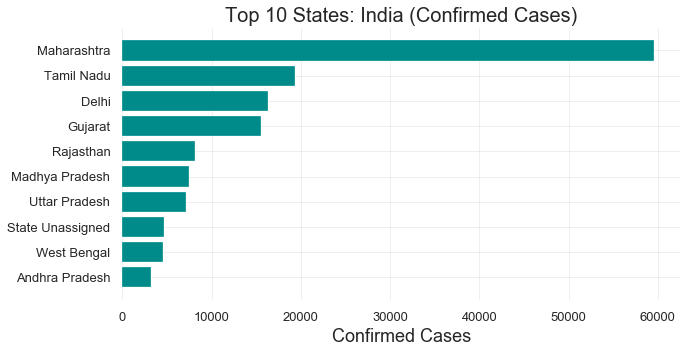

In [949]:
f = plt.figure(figsize=(10,5))
f.add_subplot(111)

plt.axes(axisbelow=True)
plt.barh(df_india.sort_values('confirmed')["confirmed"].index[-10:],df_india.sort_values('confirmed')["confirmed"].values[-10:],color="darkcyan")
plt.tick_params(size=5,labelsize = 13)
plt.xlabel("Confirmed Cases",fontsize=18)
plt.title("Top 10 States: India (Confirmed Cases)",fontsize=20)
plt.grid(alpha=0.3)
# plt.savefig(out+'Top 10 States_India (Confirmed Cases).png')

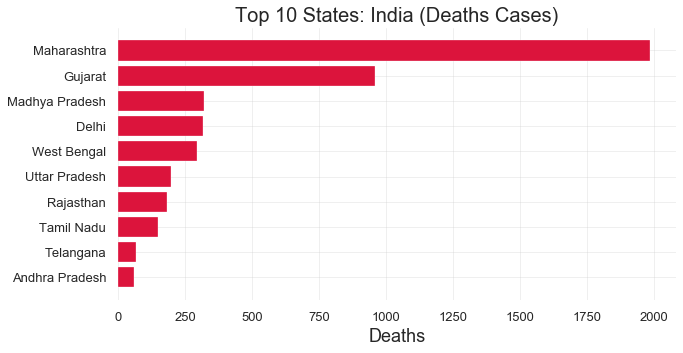

In [950]:
f = plt.figure(figsize=(10,5))
f.add_subplot(111)

plt.axes(axisbelow=True)
plt.barh(df_india.sort_values('deaths')["deaths"].index[-10:],df_india.sort_values('deaths')["deaths"].values[-10:],color="crimson")
plt.tick_params(size=5,labelsize = 13)
plt.xlabel("Deaths",fontsize=18)
plt.title("Top 10 States: India (Deaths Cases)",fontsize=20)
plt.grid(alpha=0.3)
# plt.savefig(out+'Top 10 States_India (Deaths Cases).png')

In [951]:
# Adding Location data (Latitude,Longitude)
locations = {
    "Kerala" : [10.8505,76.2711],
    "Maharashtra" : [19.7515,75.7139],
    "Karnataka": [15.3173,75.7139],
    "Telangana": [18.1124,79.0193],
    "Uttar Pradesh": [26.8467,80.9462],
    "Rajasthan": [27.0238,74.2179],
    "Gujarat":[22.2587,71.1924],
    "Delhi" : [28.7041,77.1025],
    "Punjab":[31.1471,75.3412],
    "Tamil Nadu": [11.1271,78.6569],
    "Haryana": [29.0588,76.0856],
    "Madhya Pradesh":[22.9734,78.6569],
    "Jammu and Kashmir":[33.7782,76.5762],
    "Ladakh": [34.1526,77.5770],
    "Andhra Pradesh":[15.9129,79.7400],
    "West Bengal": [22.9868,87.8550],
    "Bihar": [25.0961,85.3131],
    "Chhattisgarh":[21.2787,81.8661],
    "Chandigarh":[30.7333,76.7794],
    "Uttarakhand":[30.0668,79.0193],
    "Himachal Pradesh":[31.1048,77.1734],
    "Goa": [15.2993,74.1240],
    "Odisha":[20.9517,85.0985],
    "Andaman and Nicobar Islands": [11.7401,92.6586],
    "Puducherry":[11.9416,79.8083],
    "Manipur":[24.6637,93.9063],
    "Mizoram":[23.1645,92.9376],
    "Assam":[26.2006,92.9376],
    "Meghalaya":[25.4670,91.3662],
    "Tripura":[23.9408,91.9882],
    "Arunachal Pradesh":[28.2180,94.7278],
    "Jharkhand" : [23.6102,85.2799],
    "Nagaland": [26.1584,94.5624],
    "Sikkim": [27.5330,88.5122],
    "Dadra and Nagar Haveli":[20.1809,73.0169],
    "Lakshadweep":[10.5667,72.6417],
    "Daman and Diu":[20.4283,72.8397]    
}
df_india["Lat"] = ""
df_india["Long"] = ""

for index in df_india.index :
    if index in locations:
        df_india.loc[df_india.index == index,"Lat"] = locations[index][0]
        df_india.loc[df_india.index == index,"Long"] = locations[index][1]
    else:
        df_india.drop([index],inplace=True)

In [952]:
india = folium.Map(location=[23,80], zoom_start=4,max_zoom=6,min_zoom=4,height=500,width="80%")
for i in range(0,len(df_india[df_india['confirmed']>0].index)):
    folium.Circle(
        location=[df_india.iloc[i]['Lat'], df_india.iloc[i]['Long']],
        tooltip = "<h5 style='text-align:center;font-weight: bold'>"+df_india.iloc[i].name+"</h5>"+
                    "<hr style='margin:10px;'>"+
                    "<ul style='color: #444;list-style-type:circle;align-item:left;padding-left:20px;padding-right:20px'>"+
        "<li>Confirmed: "+str(df_india.iloc[i]['confirmed'])+"</li>"+
        "<li>Active:   "+str(df_india.iloc[i]['active'])+"</li>"+
        "<li>Recovered:   "+str(df_india.iloc[i]['recovered'])+"</li>"+
        "<li>Deaths:   "+str(df_india.iloc[i]['deaths'])+"</li>"+
        
        "<li>Mortality Rate:   "+str(np.round(df_india.iloc[i]['Mortality Rate (per 100)'],2))+"</li>"+
        "</ul>"
        ,
        radius=(int(np.log2(df_india.iloc[i]['confirmed']+1)))*15000,
        color='#ff6600',
        fill_color='#ff8533',
        fill=True).add_to(india)

india

In [953]:
df_india.head()

,confirmed,recovered,deaths,active,Mortality Rate (per 100),Lat,Long
state,,,,,,,
Maharashtra,59546,18616,1982,38948,3.330000,19.751500,75.713900
Tamil Nadu,19372,10548,148,8676,0.760000,11.127100,78.656900
Delhi,16281,7495,316,8470,1.940000,28.704100,77.102500
Gujarat,15572,8003,960,6609,6.160000,22.258700,71.192400
Rajasthan,8158,4855,182,3121,2.230000,27.023800,74.217900


In [954]:
df_india.columns

Index(['confirmed', 'recovered', 'deaths', 'active',
       'Mortality Rate (per 100)', 'Lat', 'Long'],
      dtype='object')

In [955]:
# stacked bar chart

# color pallette
dth = 'red'
rec = 'green'
act = 'orange'

datewise1 = datewise.reset_index()

# subset columns
temp = datewise1[['Date','Active Cases', 'Deaths', 'Cured']]

# rename columns
temp.columns = ['Date','Active', 'Deaths', 'Cured']

# melt data
temp = temp.melt(id_vars="Date", value_vars=['Cured', 'Deaths', 'Active'],
                 var_name='Case', value_name='Count')
temp.head()

# plot
fig_2 = px.bar(temp, x='Date', y="Count", color='Case', height=540, color_discrete_sequence = [rec, dth, act])
fig_2.update_layout(plot_bgcolor='rgba(0,0,0,0)')
fig_2.show()

In [956]:
df_india.index.unique()

Index(['Maharashtra', 'Tamil Nadu', 'Delhi', 'Gujarat', 'Rajasthan',
       'Madhya Pradesh', 'Uttar Pradesh', 'West Bengal', 'Andhra Pradesh',
       'Bihar', 'Karnataka', 'Punjab', 'Telangana', 'Jammu and Kashmir',
       'Odisha', 'Haryana', 'Kerala', 'Assam', 'Uttarakhand', 'Jharkhand',
       'Chhattisgarh', 'Chandigarh', 'Himachal Pradesh', 'Tripura', 'Goa',
       'Ladakh', 'Puducherry', 'Manipur', 'Andaman and Nicobar Islands',
       'Meghalaya', 'Nagaland', 'Arunachal Pradesh', 'Mizoram', 'Sikkim',
       'Lakshadweep'],
      dtype='object', name='state')

In [994]:
temp = df_india.reset_index()
temp = temp.loc[temp.state != 'State Unassigned']
temp['Mortality Rate (per 100)'] = (100*(temp['deaths'])/temp['confirmed']).round(3)
temp['Recovery Rate'] = (100*(temp['recovered'])/temp['confirmed']).round(3)
fig_c = px.bar(temp.sort_values('confirmed').tail(10), x="confirmed", y="state", 
               text='confirmed', orientation='h', color_discrete_sequence = ['blue'])
fig_a = px.bar(temp.sort_values('active').tail(10), x="active", y="state", 
               text='active', orientation='h', color_discrete_sequence = ['#323232'])

fig_d = px.bar(temp.sort_values('deaths').tail(10), x="deaths", y="state", 
               text='deaths', orientation='h', color_discrete_sequence = ['#ff677d'])
fig_mr = px.bar(temp[temp['confirmed']>100].sort_values('Mortality Rate (per 100)').tail(10), 
                x="Mortality Rate (per 100)", y="state", 
                text='Mortality Rate (per 100)', orientation='h', color_discrete_sequence = ['#cd6684'])

fig_r = px.bar(temp.sort_values('recovered').tail(10), x="recovered", y="state", 
               text='recovered', orientation='h', color_discrete_sequence = ['#649d66'])
fig_rr = px.bar(temp[temp['confirmed']>100].sort_values('Recovery Rate').tail(10), 
                x="Recovery Rate", y="state", 
                text='Recovery Rate', orientation='h', color_discrete_sequence = ['#16817a'])

fig = make_subplots(rows=3, cols=2, shared_xaxes=False, horizontal_spacing=0.14, vertical_spacing=0.08,
                    subplot_titles=('Confirmed cases', 'Active cases', 
                                    'Deaths reported', 'Mortality Rate (per 100)', 
                                    'Cured', 'Recovery rate (per 100)'))

fig.add_trace(fig_c['data'][0], row=1, col=1)
fig.add_trace(fig_a['data'][0], row=1, col=2)

fig.add_trace(fig_d['data'][0], row=2, col=1)
fig.add_trace(fig_mr['data'][0], row=2, col=2)

fig.add_trace(fig_r['data'][0], row=3, col=1)
fig.add_trace(fig_rr['data'][0], row=3, col=2)

# fig.update_layout(height=1200, title_text="Leading State/UT")
fig.update_layout(height=1200, plot_bgcolor='rgba(0,0,0,0)')
fig.update_xaxes(showline=True, linewidth=1, linecolor='black')
fig.update_yaxes(showline=True, linewidth=1, linecolor='black')

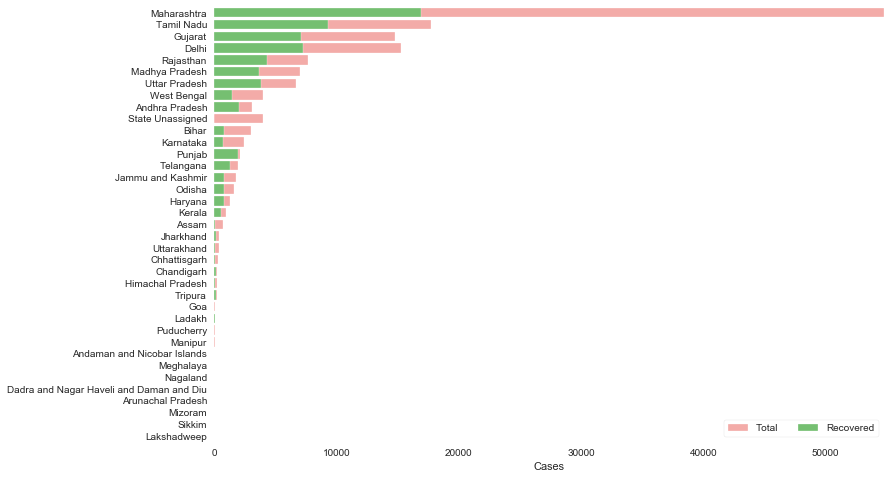

In [889]:
f, ax = plt.subplots(figsize=(12, 8))
# df_india.sort_values('confirmed',ascending=False,inplace=True)
sns.set_color_codes("pastel")
sns.barplot(x="confirmed", y=df_india.index, data=df_india,
            label="Total", color="r")

sns.set_color_codes("muted")
sns.barplot(x="recovered", y=df_india.index, data=df_india,
            label="Recovered", color="g")


# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, df_india.confirmed.max()), ylabel="",
       xlabel="Cases")
sns.despine(left=True, bottom=True)

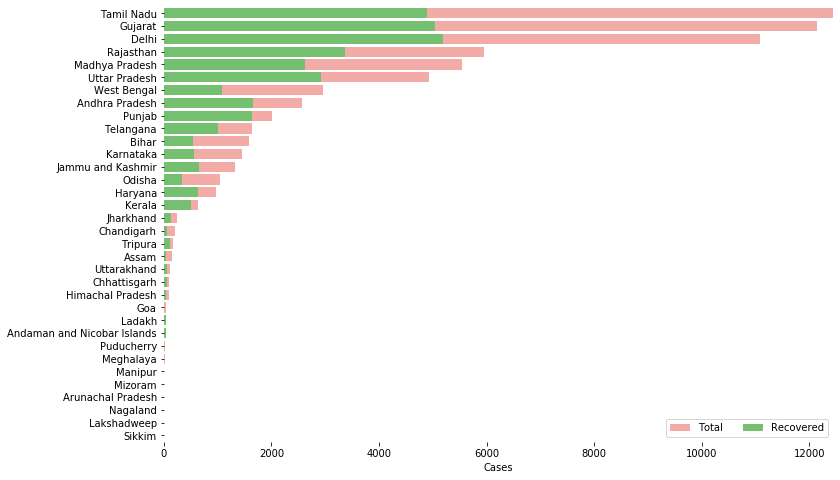

In [38]:
f, ax = plt.subplots(figsize=(12, 8))
# df_india.sort_values('confirmed',ascending=False,inplace=True)
sns.set_color_codes("pastel")
sns.barplot(x="confirmed", y=df_india.iloc[1:,:].index, data=df_india.iloc[1:,:],
            label="Total", color="r")

sns.set_color_codes("muted")
sns.barplot(x="recovered", y=df_india.iloc[1:,:].index, data=df_india.iloc[1:,:],
            label="Recovered", color="g")


# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, df_india.iloc[1:,:].confirmed.max()), ylabel="",
       xlabel="Cases")
sns.despine(left=True, bottom=True)

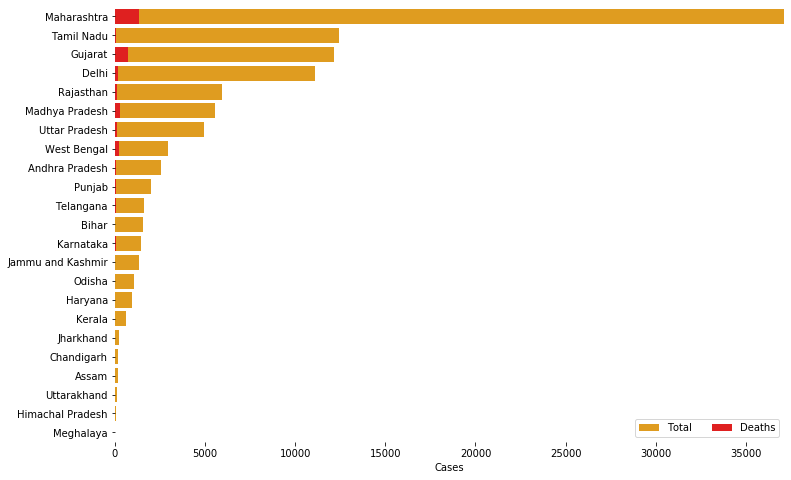

In [42]:
f, ax = plt.subplots(figsize=(12, 8))
# df_india.sort_values('confirmed',ascending=False,inplace=True)
sns.set_color_codes("pastel")
sns.barplot(x="confirmed", y=df_india[df_india['deaths']>0].index, data=df_india[df_india['deaths']>0],
            label="Total", color="orange")

sns.set_color_codes("muted")
sns.barplot(x="deaths", y=df_india[df_india['deaths']>0].index, data=df_india[df_india['deaths']>0],
            label="Deaths", color="red")


# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, df_india[df_india['deaths']>0].confirmed.max()), ylabel="",
       xlabel="Cases")
sns.despine(left=True, bottom=True)

###### State wise TS data

In [997]:
states_df = pd.read_csv('/Users/apple/Desktop/COVID/datasets_557629_1204131_covid_19_india.csv')

In [998]:
states_df.shape

(2558, 9)

In [999]:
states_df.columns

Index(['Sno', 'Date', 'Time', 'State/UnionTerritory',
       'ConfirmedIndianNational', 'ConfirmedForeignNational', 'Cured',
       'Deaths', 'Confirmed'],
      dtype='object')

In [1000]:
states_df = states_df.drop(columns = 'Sno')

In [1001]:
states_df['Date'] = pd.to_datetime(states_df['Date'])

In [1002]:
states_df.head()

,Date,Time,State/UnionTerritory,ConfirmedIndianNational,ConfirmedForeignNational,Cured,Deaths,Confirmed
0,2020-01-30,6:00 PM,Kerala,1,0,0,0,1
1,2020-01-31,6:00 PM,Kerala,1,0,0,0,1
2,2020-02-01,6:00 PM,Kerala,2,0,0,0,2
3,2020-02-02,6:00 PM,Kerala,3,0,0,0,3
4,2020-02-03,6:00 PM,Kerala,3,0,0,0,3


In [1003]:
states = states_df['State/UnionTerritory'].unique()
print(len(states))
states

37


array(['Kerala', 'Telengana', 'Delhi', 'Rajasthan', 'Uttar Pradesh',
       'Haryana', 'Ladakh', 'Tamil Nadu', 'Karnataka', 'Maharashtra',
       'Punjab', 'Jammu and Kashmir', 'Andhra Pradesh', 'Uttarakhand',
       'Odisha', 'Puducherry', 'West Bengal', 'Chhattisgarh',
       'Chandigarh', 'Gujarat', 'Himachal Pradesh', 'Madhya Pradesh',
       'Bihar', 'Manipur', 'Mizoram', 'Andaman and Nicobar Islands',
       'Goa', 'Unassigned', 'Assam', 'Jharkhand', 'Arunachal Pradesh',
       'Tripura', 'Nagaland', 'Meghalaya', 'Dadar Nagar Haveli',
       'Cases being reassigned to states', 'Sikkim'], dtype=object)

In [1004]:
states_df = states_df.loc[(states_df['State/UnionTerritory'] != 'Jharkhand#') & (states_df['State/UnionTerritory'] != 'Jharkhand#') & (states_df['State/UnionTerritory'] != 'Nagaland#') & (states_df['State/UnionTerritory'] != 'Cases being reassigned to states')& (states_df['State/UnionTerritory'] != 'Unassigned')]

In [1005]:
states = states_df['State/UnionTerritory'].unique()

In [1006]:
len(states)

35

In [1007]:
states_df.index = states_df['Date']
states_df = states_df.drop(columns = ['Date'])

/Users/apple/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/Users/apple/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/Users/apple/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this w

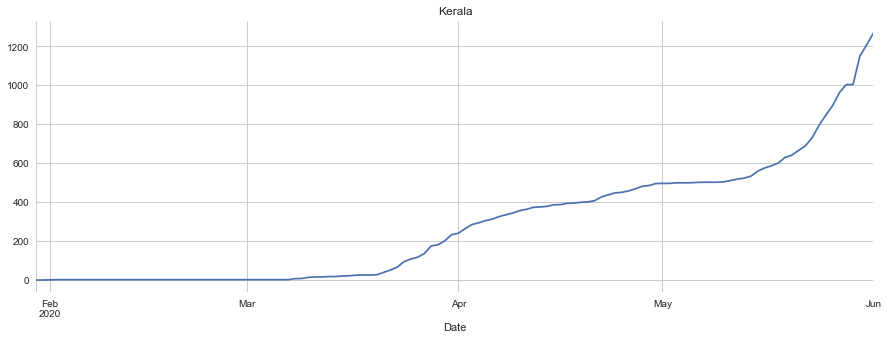

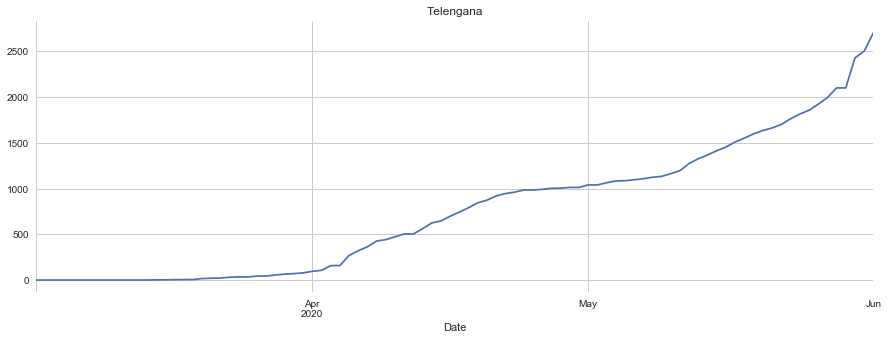

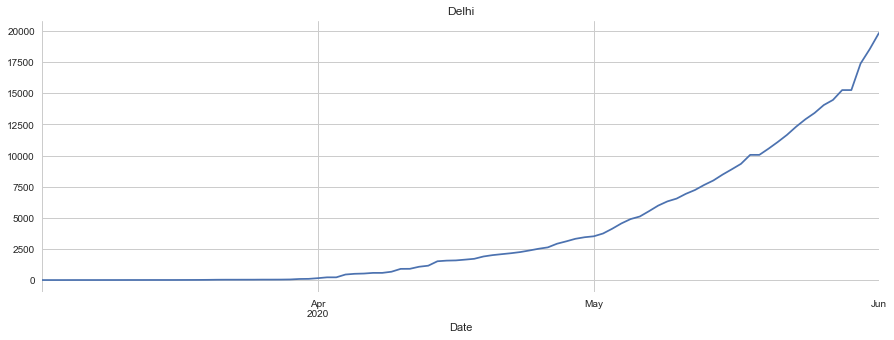

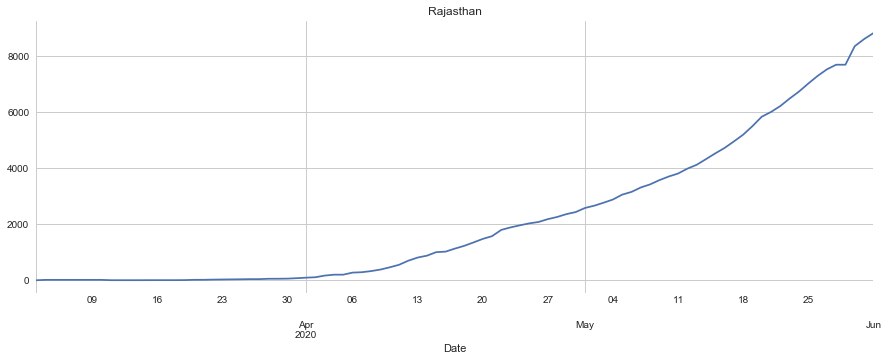

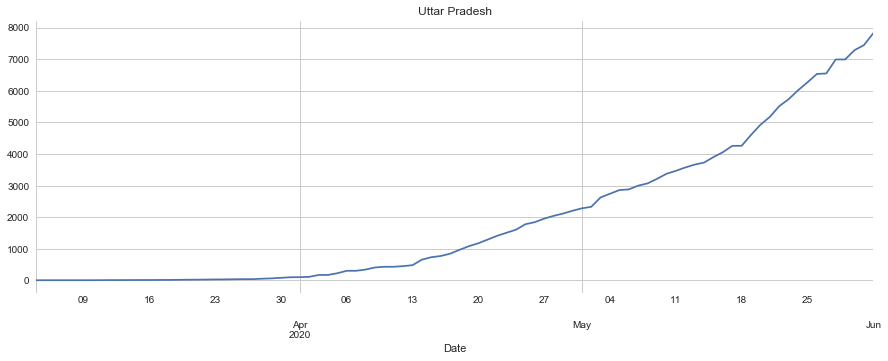

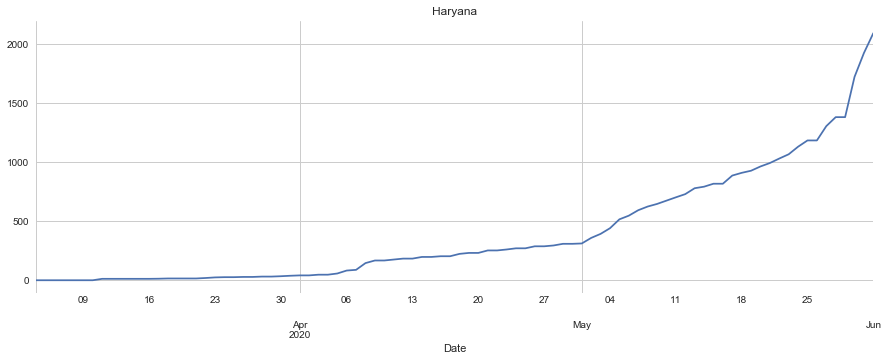

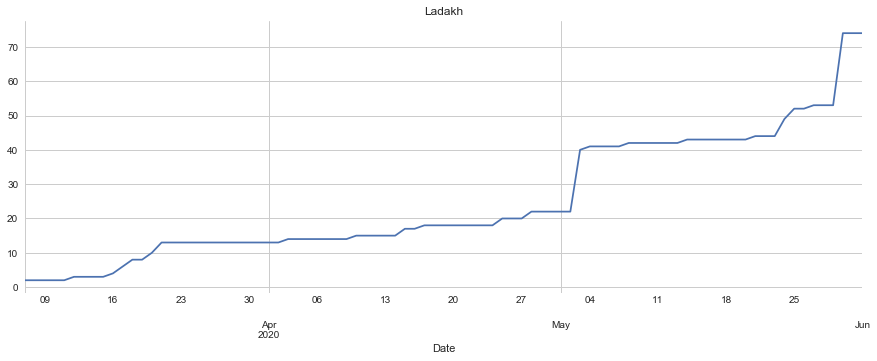

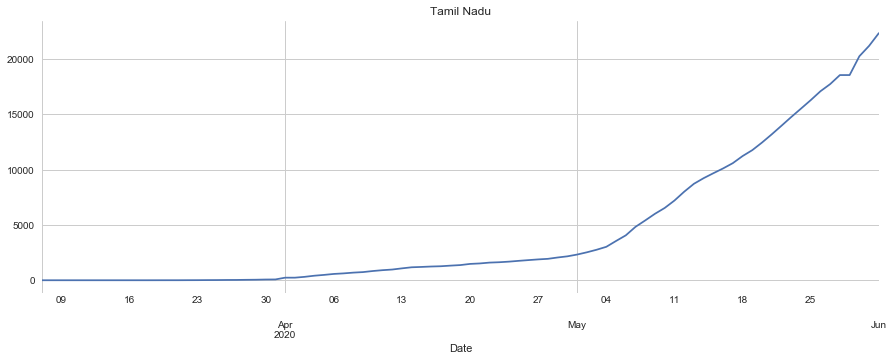

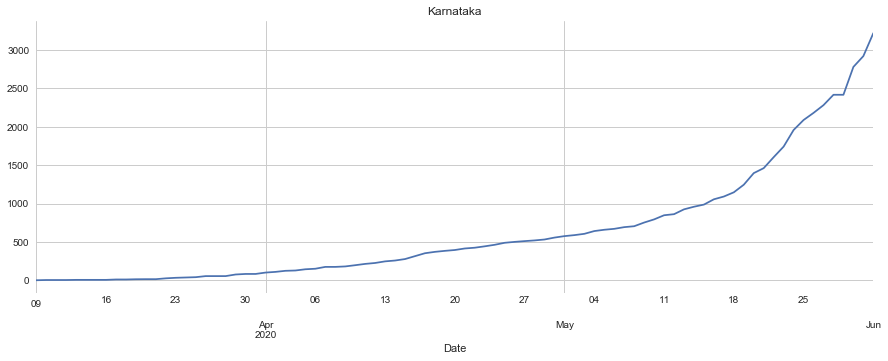

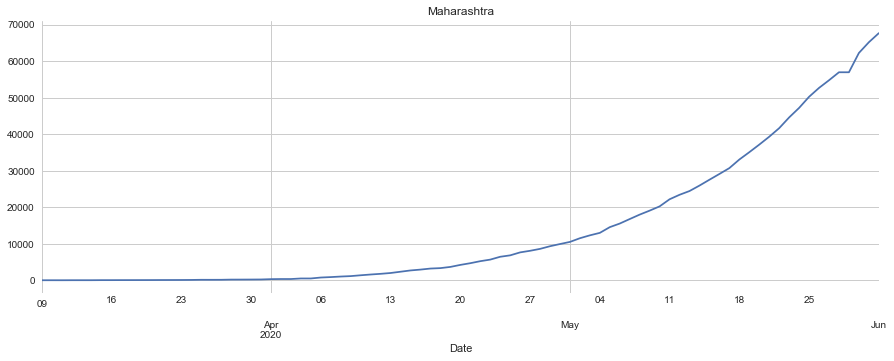

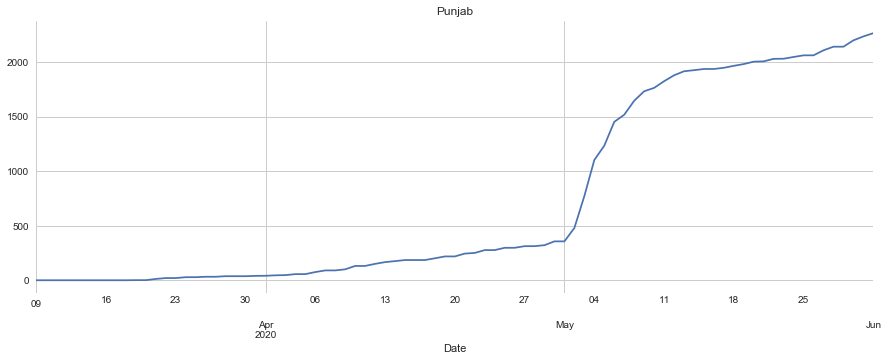

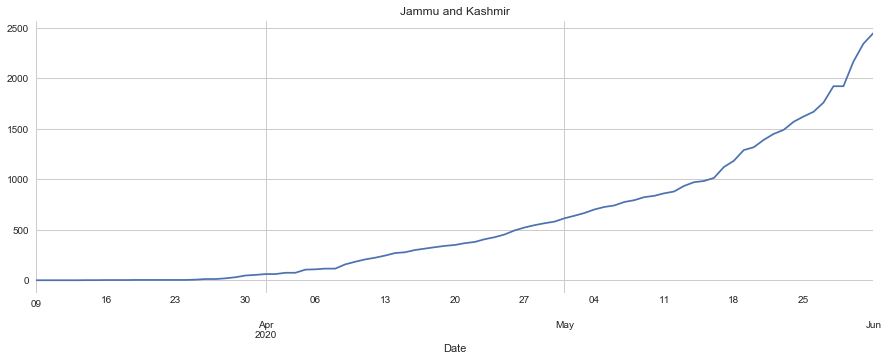

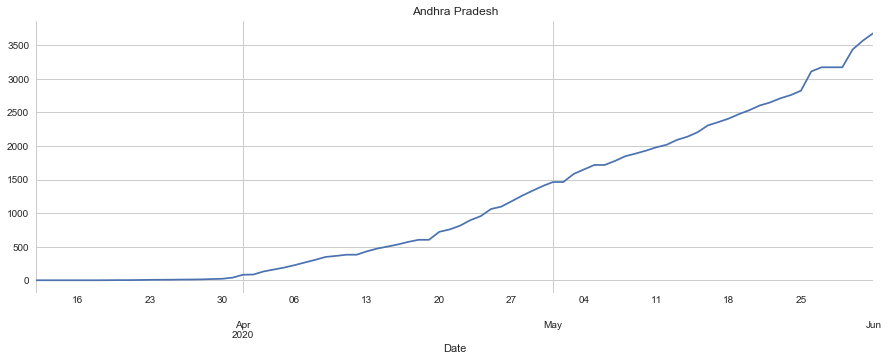

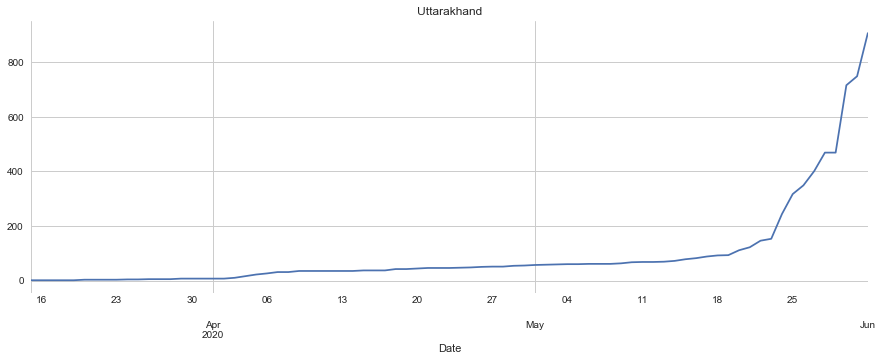

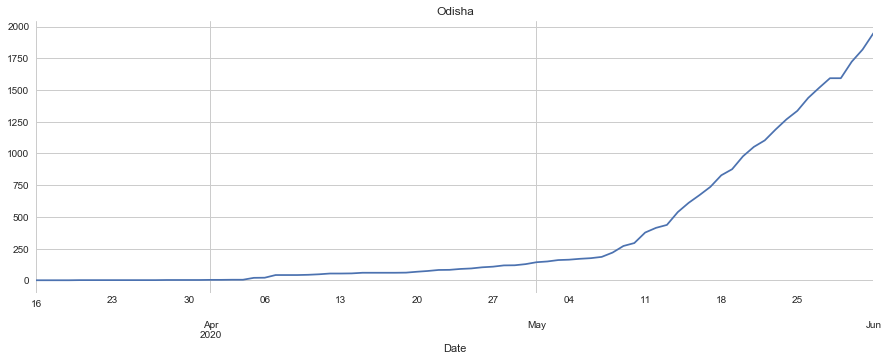

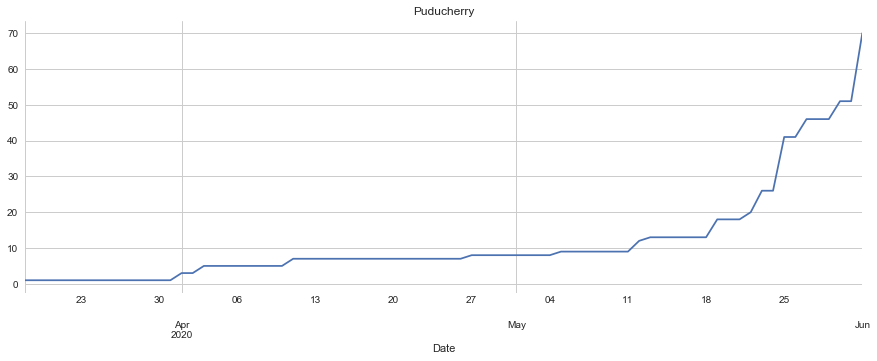

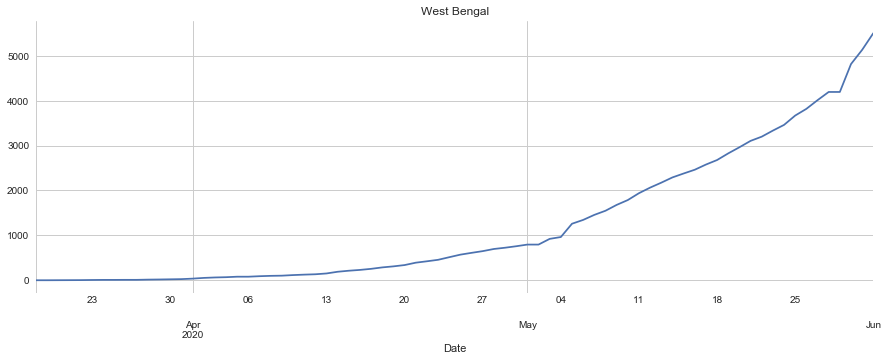

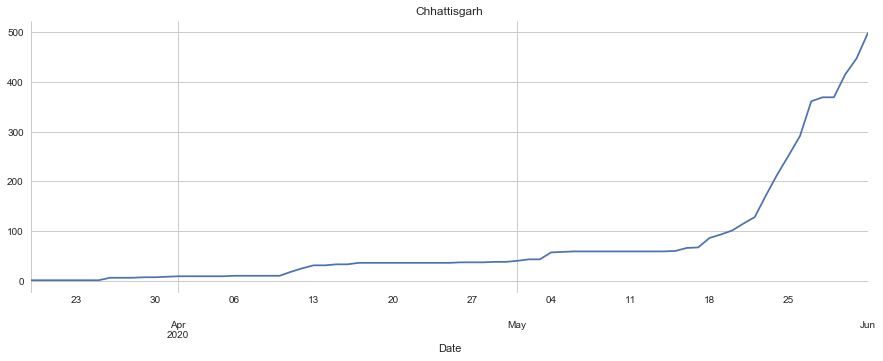

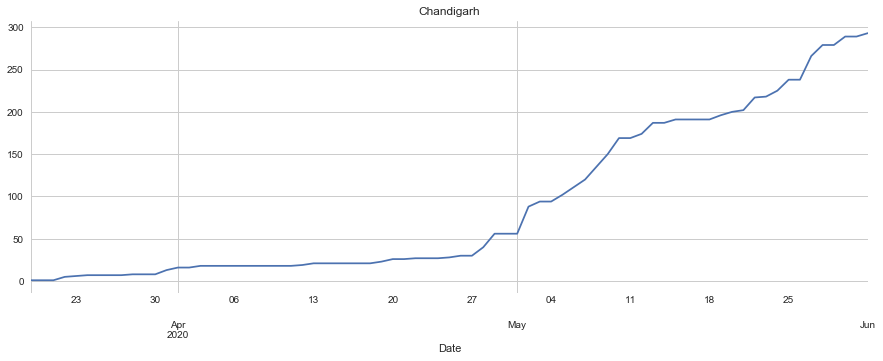

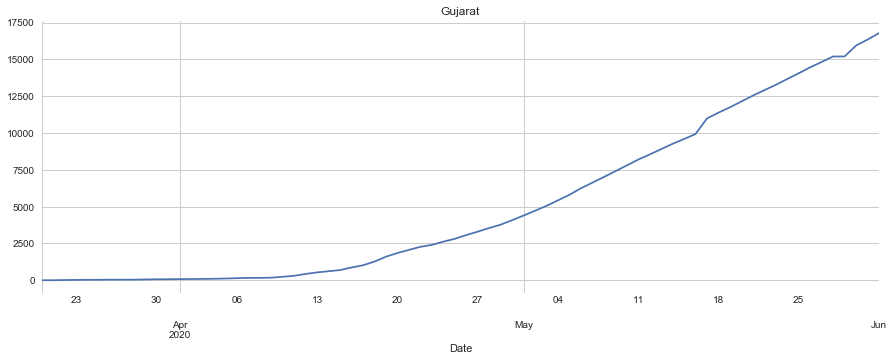

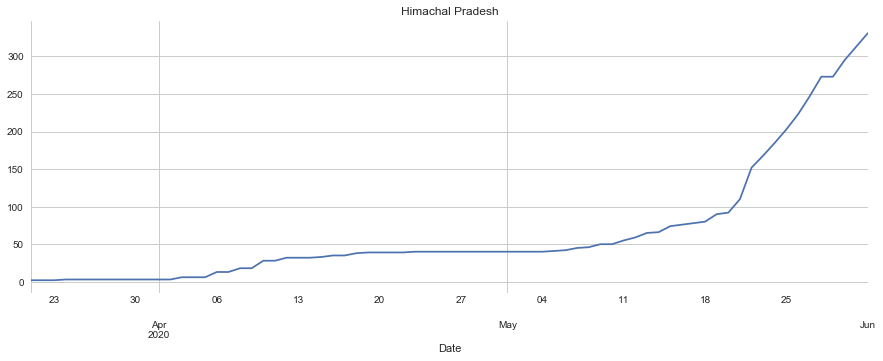

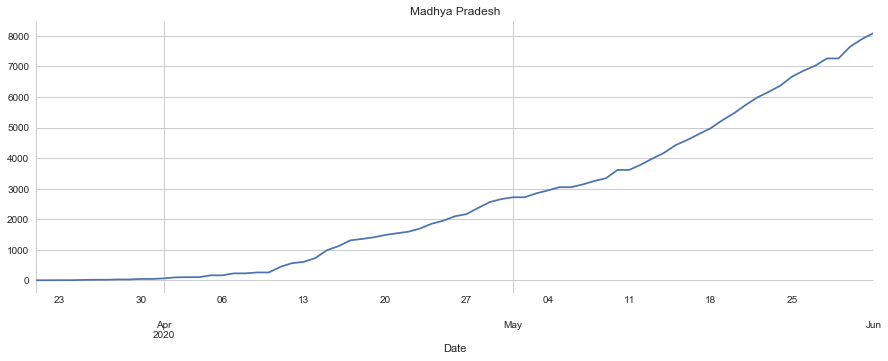

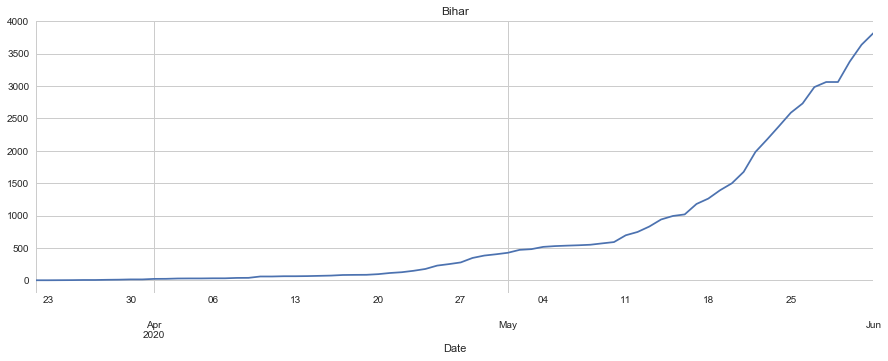

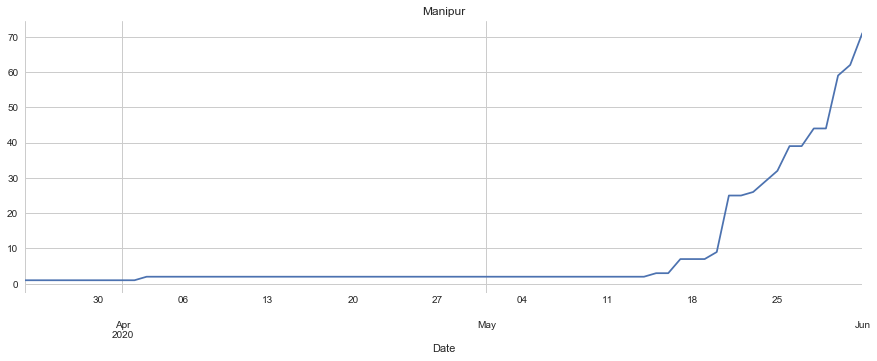

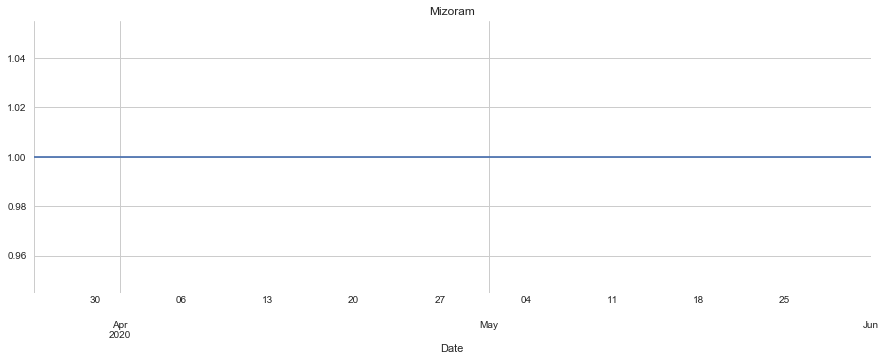

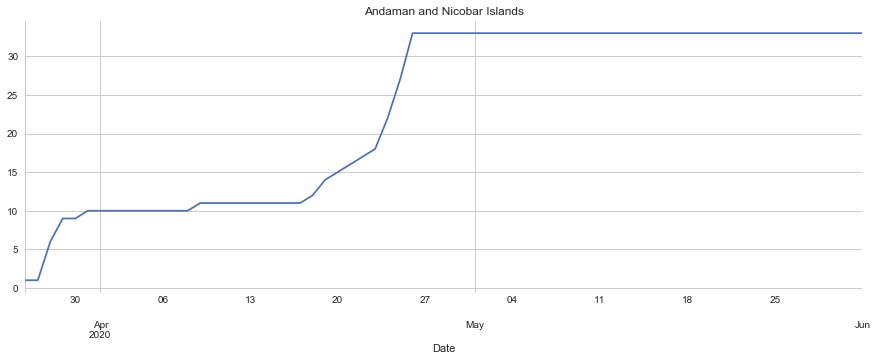

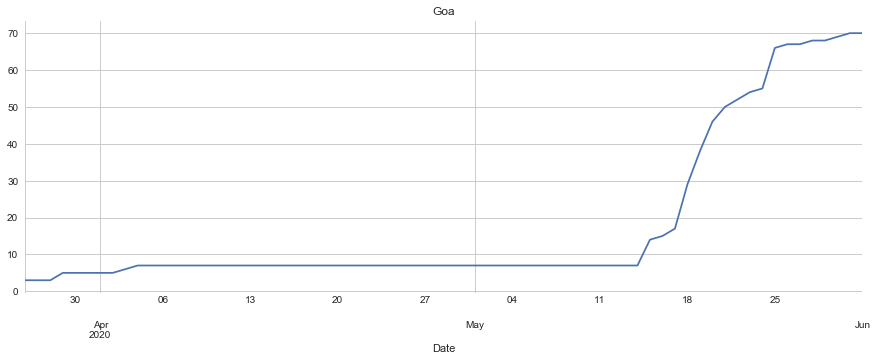

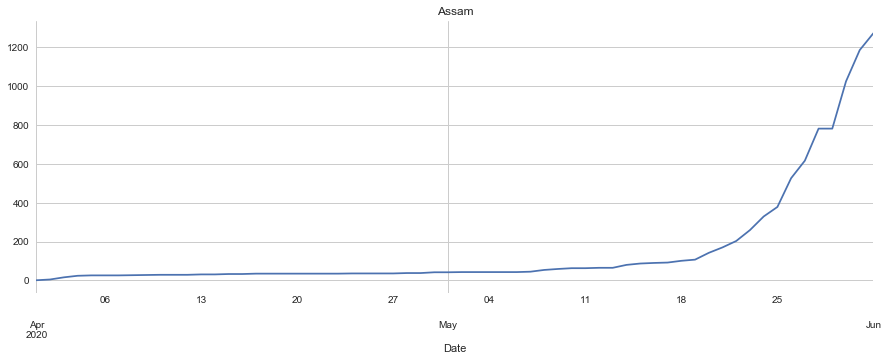

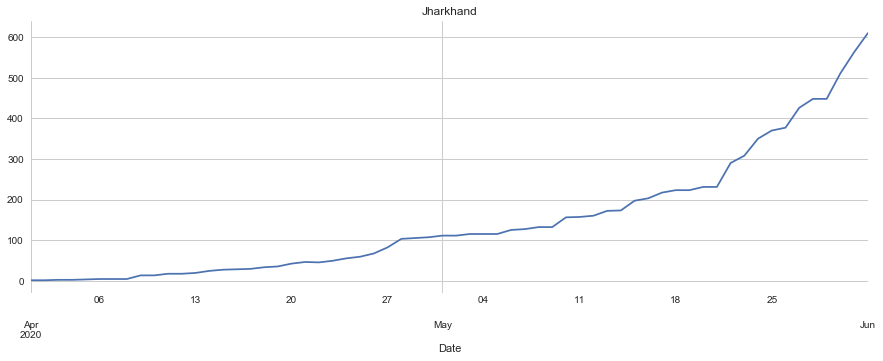

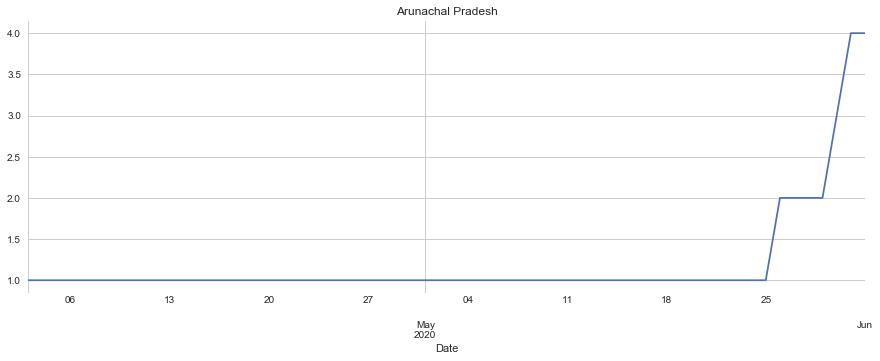

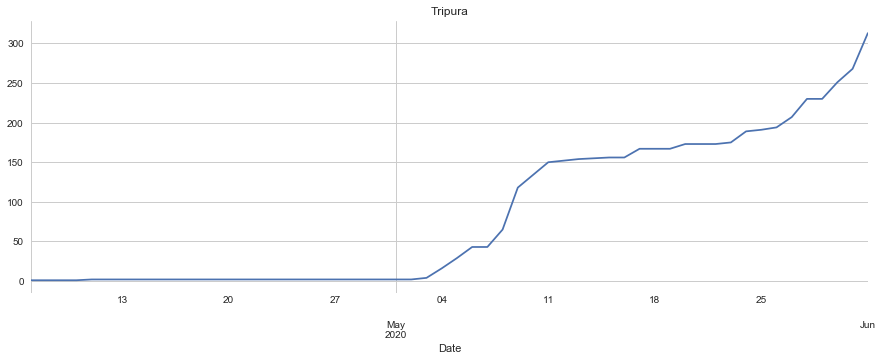

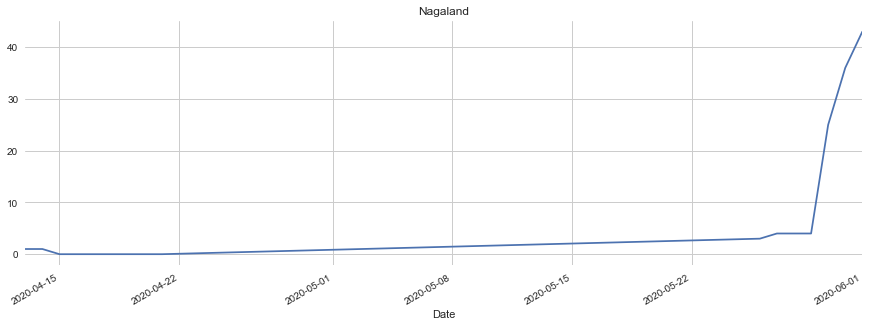

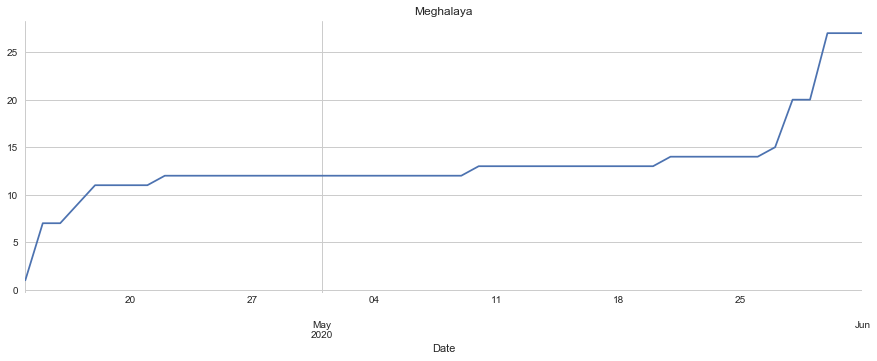

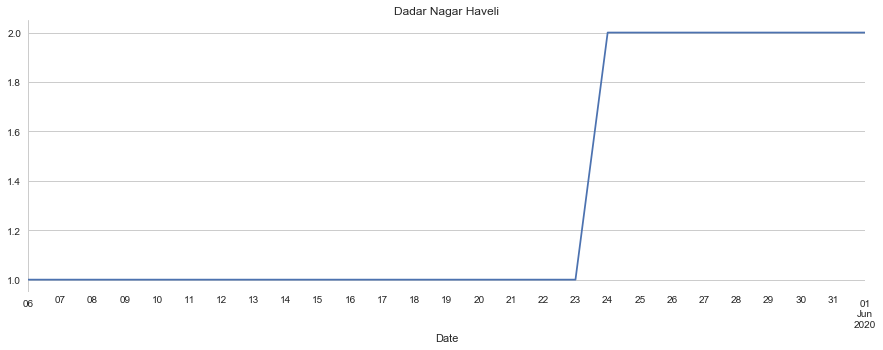

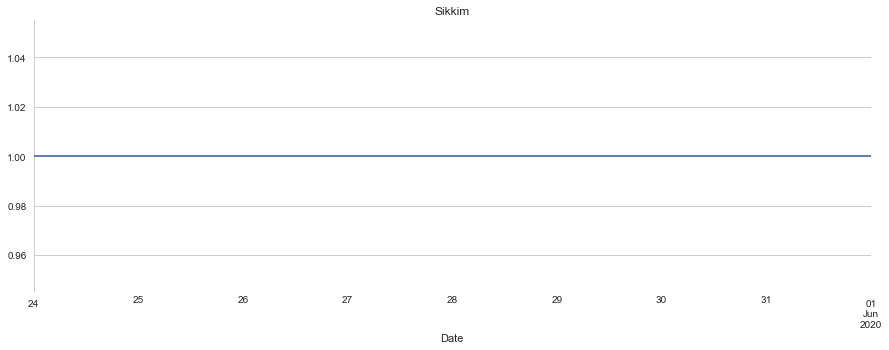

In [1008]:
for i in states:
    plt.figure()
    states_df[states_df['State/UnionTerritory']==i]['Confirmed'].plot(title = i,figsize = (15,5))

In [1009]:
states_df[states_df['State/UnionTerritory']=='Kerala']['Confirmed']

Date
2020-01-30       1
2020-01-31       1
2020-02-01       2
2020-02-02       3
2020-02-03       3
              ... 
2020-05-28    1004
2020-05-29    1004
2020-05-30    1150
2020-05-31    1208
2020-06-01    1269
Name: Confirmed, Length: 124, dtype: int64

In [1010]:
states_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2542 entries, 2020-01-30 to 2020-06-01
Data columns (total 7 columns):
Time                        2542 non-null object
State/UnionTerritory        2542 non-null object
ConfirmedIndianNational     2542 non-null object
ConfirmedForeignNational    2542 non-null object
Cured                       2542 non-null int64
Deaths                      2542 non-null int64
Confirmed                   2542 non-null int64
dtypes: int64(3), object(4)
memory usage: 158.9+ KB


In [1011]:
states_df['Deaths'] = states_df['Deaths'].replace('0#',0).astype('int64')

In [1012]:
states_df['Active'] = states_df['Confirmed'] - states_df['Cured'] - states_df['Deaths']
states_df['Active'] = states_df['Active'].astype('int64')

In [1013]:
states

array(['Kerala', 'Telengana', 'Delhi', 'Rajasthan', 'Uttar Pradesh',
       'Haryana', 'Ladakh', 'Tamil Nadu', 'Karnataka', 'Maharashtra',
       'Punjab', 'Jammu and Kashmir', 'Andhra Pradesh', 'Uttarakhand',
       'Odisha', 'Puducherry', 'West Bengal', 'Chhattisgarh',
       'Chandigarh', 'Gujarat', 'Himachal Pradesh', 'Madhya Pradesh',
       'Bihar', 'Manipur', 'Mizoram', 'Andaman and Nicobar Islands',
       'Goa', 'Assam', 'Jharkhand', 'Arunachal Pradesh', 'Tripura',
       'Nagaland', 'Meghalaya', 'Dadar Nagar Haveli', 'Sikkim'],
      dtype=object)

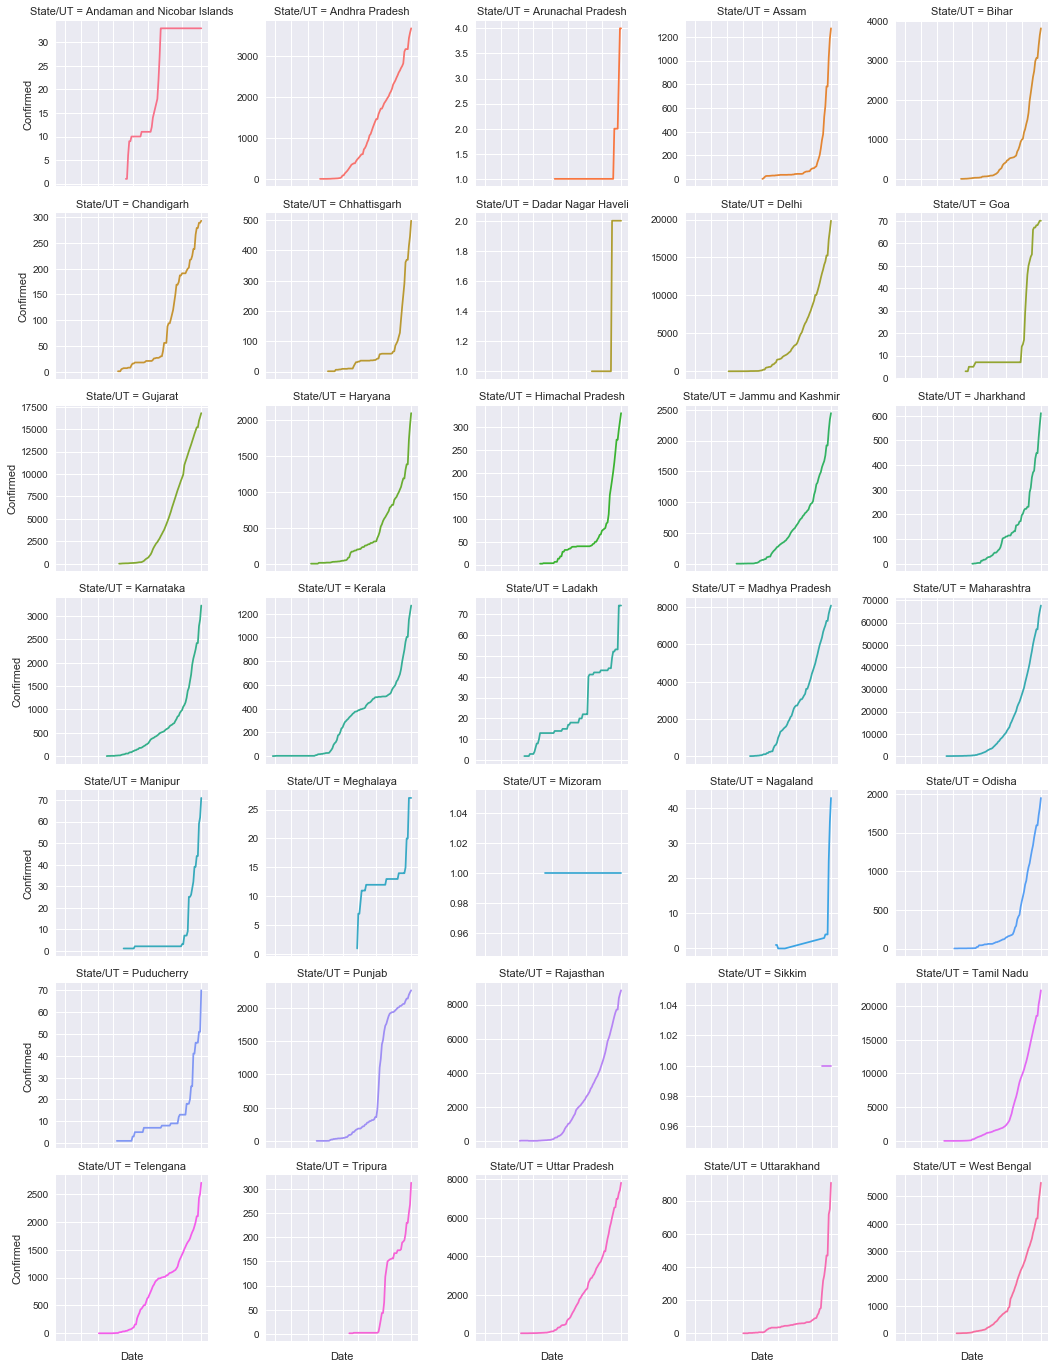

In [1014]:
plt.style.use('seaborn')
temp = states_df.reset_index()
temp = temp.rename(columns = {'State/UnionTerritory' : 'State/UT'})
g = sns.FacetGrid(temp.sort_values(['State/UT','Date']), 
                  col="State/UT", hue="State/UT", 
                  sharey=False, col_wrap=5)
g = g.map(plt.plot, 'Date', "Confirmed")
g.set_xticklabels(rotation=90)
g.fig.subplots_adjust(top=0.9)
# g.fig.suptitle('Confirmed case in each state over time', 
#                fontsize=20)
plt.show()

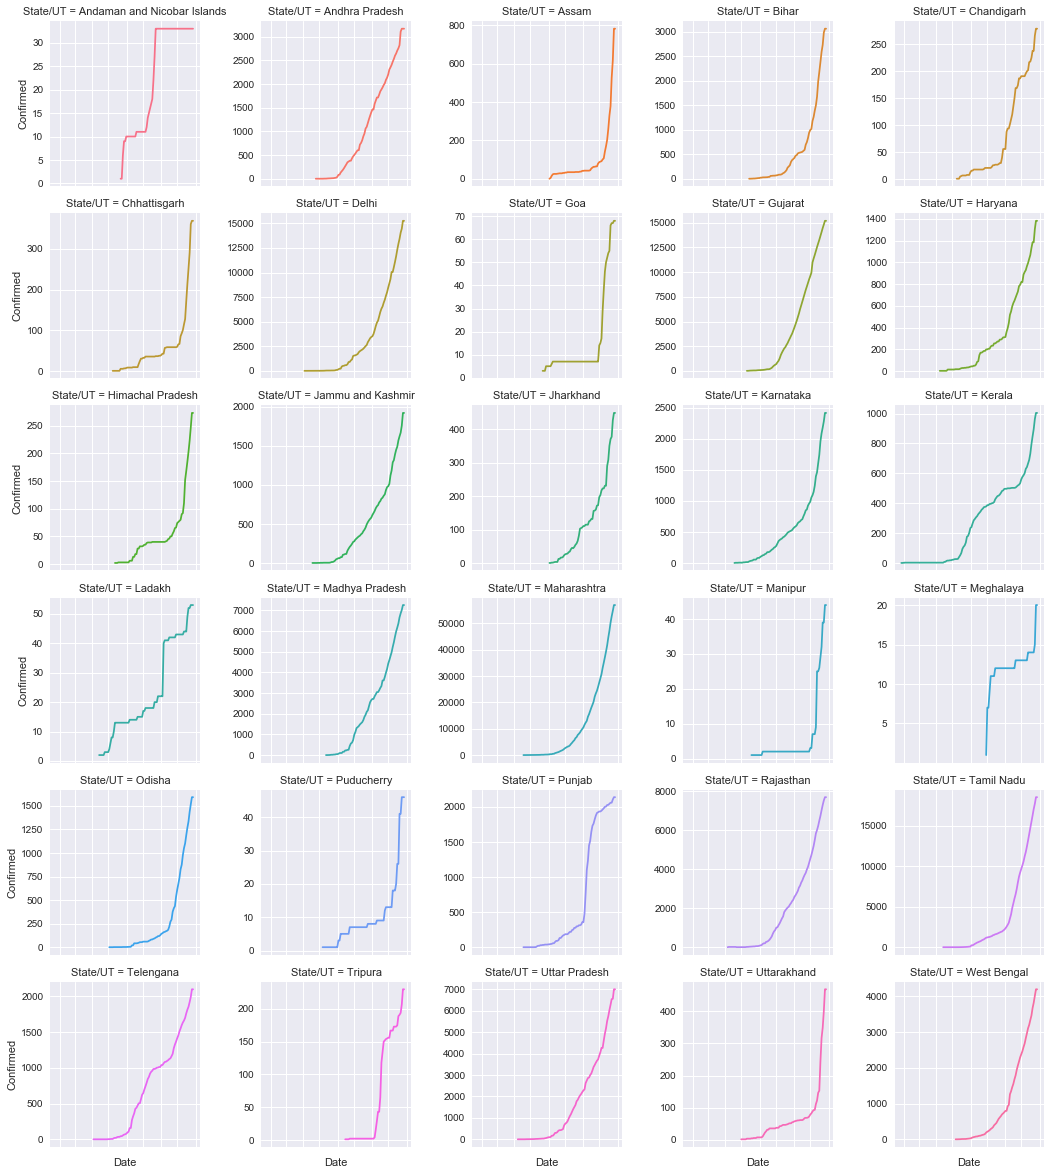

In [941]:
plt.style.use('seaborn')
temp = states_df.reset_index()
temp = temp.rename(columns = {'State/UnionTerritory' : 'State/UT'})
list1 = ['Kerala', 'Telengana', 'Delhi', 'Rajasthan', 'Uttar Pradesh',
       'Haryana', 'Ladakh', 'Tamil Nadu', 'Karnataka', 'Maharashtra',
       'Punjab', 'Jammu and Kashmir', 'Andhra Pradesh', 'Uttarakhand',
       'Odisha', 'Puducherry', 'West Bengal', 'Chhattisgarh',
       'Chandigarh', 'Gujarat', 'Himachal Pradesh', 'Madhya Pradesh',
       'Bihar', 'Manipur', 'Andaman and Nicobar Islands',
       'Goa', 'Assam', 'Jharkhand', 'Tripura', 'Meghalaya']

# 'Sikkim' ,  'Mizoram', 'Dadar Nagar Haveli', 'Nagaland', 'Arunachal Pradesh' 
temp = temp[temp['State/UT'].isin(list1)]
g = sns.FacetGrid(temp.sort_values(['State/UT','Date']), 
                  col="State/UT", hue="State/UT", 
                  sharey=False, col_wrap=5)
g = g.map(plt.plot, 'Date', "Confirmed")
g.set_xticklabels(rotation=90)
g.fig.subplots_adjust(top=0.9)
# g.fig.suptitle('Confirmed case in each state over time', 
#                fontsize=20)
plt.show()

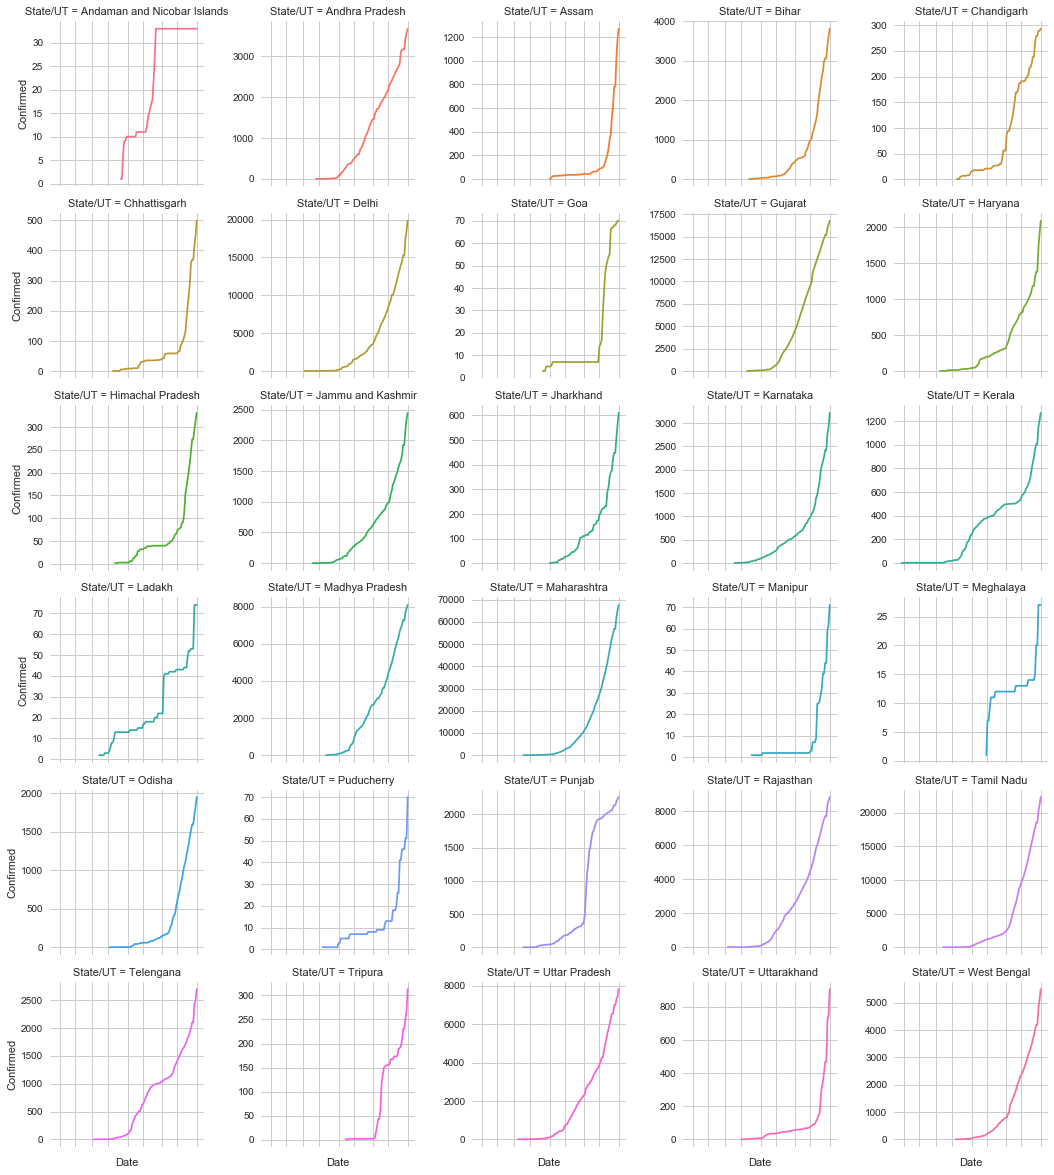

In [1015]:
plt.style.use('seaborn')
sns.set_style("whitegrid", {'axes.grid' : True})
temp = states_df.reset_index()
temp = temp.rename(columns = {'State/UnionTerritory' : 'State/UT'})
list1 = ['Kerala', 'Telengana', 'Delhi', 'Rajasthan', 'Uttar Pradesh',
       'Haryana', 'Ladakh', 'Tamil Nadu', 'Karnataka', 'Maharashtra',
       'Punjab', 'Jammu and Kashmir', 'Andhra Pradesh', 'Uttarakhand',
       'Odisha', 'Puducherry', 'West Bengal', 'Chhattisgarh',
       'Chandigarh', 'Gujarat', 'Himachal Pradesh', 'Madhya Pradesh',
       'Bihar', 'Manipur', 'Andaman and Nicobar Islands',
       'Goa', 'Assam', 'Jharkhand', 'Tripura', 'Meghalaya']

# 'Sikkim' ,  'Mizoram', 'Dadar Nagar Haveli', 'Nagaland', 'Arunachal Pradesh' 
temp = temp[temp['State/UT'].isin(list1)]
g = sns.FacetGrid(temp.sort_values(['State/UT','Date']), 
                  col="State/UT", hue="State/UT", 
                  sharey=False, col_wrap=5)
g = g.map(plt.plot, 'Date', "Confirmed")
g.set_xticklabels(rotation=90)
g.fig.subplots_adjust(top=0.9)
# g.fig.suptitle('Confirmed case in each state over time', 
#                fontsize=20)
plt.show()

In [1016]:
states_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2542 entries, 2020-01-30 to 2020-06-01
Data columns (total 8 columns):
Time                        2542 non-null object
State/UnionTerritory        2542 non-null object
ConfirmedIndianNational     2542 non-null object
ConfirmedForeignNational    2542 non-null object
Cured                       2542 non-null int64
Deaths                      2542 non-null int64
Confirmed                   2542 non-null int64
Active                      2542 non-null int64
dtypes: int64(4), object(4)
memory usage: 258.7+ KB


In [1017]:
states_df['Deaths'].groupby(states_df.index).agg({'Deaths' : 'sum'})

/Users/apple/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning:

using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)




,Deaths
Date,
2020-01-30,0
2020-01-31,0
2020-02-01,0
2020-02-02,0
2020-02-03,0
...,...
2020-05-28,4531
2020-05-29,4531
2020-05-30,4971


In [1018]:
aggregate = {'Confirmed':'sum', 'Cured':'sum','Deaths' : 'sum', 'Active' : 'sum'}
datewise  = states_df.groupby(states_df.index).agg(aggregate)
# datewise.index = pd.to_datetime(datewise.index)
# datewise.index = datewise.index.strftime('%Y-%m-%d') 
datewise.index = pd.to_datetime(datewise.index)
datewise["Days Since"]=datewise.index-datewise.index.min()

In [1020]:
datewise["Days Since"] = datewise["Days Since"].dt.days

In [1021]:
datewise

,Confirmed,Cured,Deaths,Active,Days Since
Date,,,,,
2020-01-30,1,0,0,1,0
2020-01-31,1,0,0,1,1
2020-02-01,2,0,0,2,2
2020-02-02,3,0,0,3,3
2020-02-03,3,0,0,3,4
...,...,...,...,...,...
2020-05-28,154001,67692,4531,81778,119
2020-05-29,154001,67692,4531,81778,120
2020-05-30,168720,82370,4971,81379,121


In [1022]:
datewise["WeekOfYear"]=datewise.index.weekofyear

week_num=[]
weekwise_confirmed=[]
weekwise_recovered=[]
weekwise_deaths=[]
weekwise_active=[]
w=1
for i in list(datewise["WeekOfYear"].unique()):
    weekwise_confirmed.append(datewise[datewise["WeekOfYear"]==i]["Confirmed"].iloc[-1])
    weekwise_recovered.append(datewise[datewise["WeekOfYear"]==i]["Cured"].iloc[-1])
    weekwise_deaths.append(datewise[datewise["WeekOfYear"]==i]["Deaths"].iloc[-1])
    weekwise_active.append(datewise[datewise["WeekOfYear"]==i]["Active"].iloc[-1])
    week_num.append(w)
    w=w+1

fig=go.Figure()
fig.add_trace(go.Scatter(x=week_num, y=weekwise_confirmed,
                    mode='lines+markers',
                    name='Weekly Growth of Confirmed Cases'))
fig.add_trace(go.Scatter(x=week_num, y=weekwise_deaths,
                    mode='lines+markers',
                    name='Weekly Growth of Death Cases'))
fig.add_trace(go.Scatter(x=week_num, y=weekwise_recovered,
                    mode='lines+markers',
                    name='Weekly Growth of Recovered Cases'))
fig.add_trace(go.Scatter(x=week_num, y=weekwise_active,
                    mode='lines+markers',
                    name='Weekly Growth of Active Cases'))
# fig.update_layout(title="Weekly Growth of different types of Cases in India",
#                  xaxis_title="Week Number",yaxis_title="Number of Cases",legend=dict(x=0,y=1,traceorder="normal"), plot_bgcolor='rgba(0,0,0,0)')
fig.update_layout(xaxis_title="Week Number",yaxis_title="Number of Cases",legend=dict(x=0,y=1,traceorder="normal"), plot_bgcolor='rgba(0,0,0,0)')
fig.show()

In [1023]:
fig=px.bar(x=datewise.index,y=datewise["Confirmed"]-datewise["Cured"]-datewise["Deaths"])
# fig.update_layout(title="Distribution of Number of Active Cases",
#                   xaxis_title="Date",yaxis_title="Number of Cases", plot_bgcolor='rgba(0,0,0,0)')
fig.update_layout(
                  xaxis_title="Date",yaxis_title="Number of Cases", plot_bgcolor='rgba(0,0,0,0)')
fig.show()

In [1024]:
fig=px.bar(x=datewise.index,y=datewise["Cured"]+datewise["Deaths"])
# fig.update_layout(title="Distribution of Number of Closed Cases",
#                   xaxis_title="Date",yaxis_title="Number of Cases", plot_bgcolor='rgba(0,0,0,0)')
fig.update_layout(
                  xaxis_title="Date",yaxis_title="Number of Cases", plot_bgcolor='rgba(0,0,0,0)')
fig.show()

Text(0.5, 1.0, 'Death Cases (Weekly)')

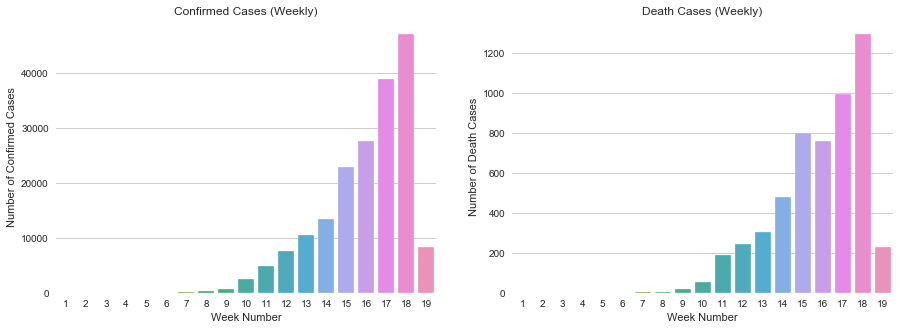

In [1025]:
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(15,5))
sns.barplot(x=week_num,y=pd.Series(weekwise_confirmed).diff().fillna(0),ax=ax1)
sns.barplot(x=week_num,y=pd.Series(weekwise_deaths).diff().fillna(0),ax=ax2)
ax1.set_xlabel("Week Number")
ax2.set_xlabel("Week Number")
ax1.set_ylabel("Number of Confirmed Cases")
ax2.set_ylabel("Number of Death Cases")
ax1.set_title("Confirmed Cases (Weekly)")
ax2.set_title("Death Cases (Weekly)")


In [1133]:
#Calculating the Mortality Rate and Recovery Rate
datewise["Mortality Rate"]=(datewise["Deaths"]/datewise["Confirmed"])*100
datewise["Recovery Rate"]=(datewise["Cured"]/datewise["Confirmed"])*100
datewise["Active Cases"]=datewise["Confirmed"]-datewise["Cured"]-datewise["Deaths"]
datewise["Closed Cases"]=datewise["Cured"]+datewise["Deaths"]

print("Average Mortality Rate",datewise["Mortality Rate"].mean())
print("Median Mortality Rate",datewise["Mortality Rate"].median())
print("Average Recovery Rate",datewise["Recovery Rate"].mean())
print("Median Recovery Rate",datewise["Recovery Rate"].median())

#Plotting Mortality and Recovery Rate 
fig = make_subplots(rows=1, cols=2,
                   subplot_titles=("Recovery Rate", "Mortatlity Rate"))
fig.add_trace(
    go.Scatter(x=datewise.index, y=(datewise["Cured"]/datewise["Confirmed"])*100,name="Recovery Rate"),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=datewise.index, y=(datewise["Deaths"]/datewise["Confirmed"])*100,name="Mortality Rate"),
    row=1, col=2
)
fig.update_layout(height=400,showlegend=False, plot_bgcolor='rgba(0,0,0,0)')
fig.update_xaxes(title_text="Date", row=1, col=1)
fig.update_yaxes(title_text="Recovery Rate", row=1, col=1)
fig.update_xaxes(title_text="Date", row=1, col=2)
fig.update_yaxes(title_text="Mortality Rate", row=1, col=2)
fig.update_xaxes(showline=True, linewidth=1, linecolor='black')
fig.update_yaxes(showline=True, linewidth=1, linecolor='black')
fig.show()

Average Mortality Rate 1.8506263666046514
Median Mortality Rate 2.4757638537449393
Average Recovery Rate 15.015619283055264
Median Recovery Rate 9.262833412608394


In [1196]:
temp = datewise[datewise.index <= '2020-06-01']

print("Average increase in number of Confirmed Cases every day: ",np.round(temp["Confirmed"].diff().fillna(0).mean()))
print("Average increase in number of Recovered Cases every day: ",np.round(temp["Cured"].diff().fillna(0).mean()))
print("Average increase in number of Deaths Cases every day: ",np.round(temp["Deaths"].diff().fillna(0).mean()))

fig=go.Figure()
fig.add_trace(go.Scatter(x=temp.index, y=temp["Confirmed"].diff().fillna(0),mode='lines+markers',
                    name='Confirmed Cases'))
fig.add_trace(go.Scatter(x=temp.index, y=temp["Deaths"].diff().fillna(0),mode='lines+markers',
                    name='Death Cases'))
fig.add_trace(go.Scatter(x=temp.index, y=temp["Cured"].diff().fillna(0),mode='lines+markers',
                    name='Recovered Cases'))
# fig.update_layout(title="Daily increase in different types of Cases",
#                  xaxis_title="Date",yaxis_title="Number of Cases",legend=dict(x=0,y=1,traceorder="normal"),plot_bgcolor='rgba(0,0,0,0)')
fig.update_layout(
                 xaxis_title="Date",yaxis_title="Number of Cases",legend=dict(x=0,y=1,traceorder="normal"),plot_bgcolor='rgba(0,0,0,0)')
fig.update_xaxes(showline=True, linewidth=1, linecolor='black')
fig.update_yaxes(showline=True, linewidth=1, linecolor='black')
fig.show()

Average increase in number of Confirmed Cases every day:  1491.0
Average increase in number of Recovered Cases every day:  740.0
Average increase in number of Deaths Cases every day:  44.0


In [1032]:
fig=go.Figure()
for state in df_india.sort_values('deaths')["deaths"].index[-10:]:
    fig.add_trace(go.Scatter(x=states_df[states_df['State/UnionTerritory'] == state].index, y=states_df[states_df['State/UnionTerritory'] == state]["Confirmed"].rolling(window=7).mean().diff(),
                    mode='lines',name=state))
# fig.update_layout(height=800,title="7 Days Rolling Average of Daily increase of Confirmed Cases",
#                  xaxis_title="Date",yaxis_title="Confirmed Cases",
#                  legend=dict(x=0,y=1,traceorder="normal"), plot_bgcolor='rgba(0,0,0,0)')
fig.update_layout(height=800,
                 xaxis_title="Date",yaxis_title="Confirmed Cases",
                 legend=dict(x=0,y=1,traceorder="normal"), plot_bgcolor='rgba(0,0,0,0)')
fig.update_xaxes(showline=True, linewidth=1, linecolor='black')
fig.update_yaxes(showline=True, linewidth=1, linecolor='black')
fig.show()

In [1033]:
fig=go.Figure()
for state in df_india.sort_values('deaths')["deaths"].index[-5:]:
    fig.add_trace(go.Scatter(x=states_df[states_df['State/UnionTerritory'] == state].index, y=states_df[states_df['State/UnionTerritory'] == state]["Confirmed"].rolling(window=14).mean().diff(),
                    mode='lines',name=state))
fig.update_layout(height=800,title="14 Days Rolling Average of Daily increase of Confirmed Cases",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",
                 legend=dict(x=0,y=1,traceorder="normal"), plot_bgcolor='rgba(0,0,0,0)')
fig.update_xaxes(showline=True, linewidth=1, linecolor='black')
fig.update_yaxes(showline=True, linewidth=1, linecolor='black')
fig.show()

In [358]:
india_increase_confirm=[]
india_increase_recover=[]
india_increase_deaths=[]
for i in range(datewise.shape[0]-1):
    india_increase_confirm.append(((datewise["Confirmed"].iloc[i+1])/datewise["Confirmed"].iloc[i]))
    india_increase_recover.append(((datewise["Cured"].iloc[i+1])/datewise["Cured"].iloc[i]))
    india_increase_deaths.append(((datewise["Deaths"].iloc[i+1])/datewise["Deaths"].iloc[i]))
india_increase_confirm.insert(0,1)
india_increase_recover.insert(0,1)
india_increase_deaths.insert(0,1)

fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise.index, y=india_increase_confirm,
                    mode='lines',
                    name='Growth Factor of Confirmed Cases'))
fig.add_trace(go.Scatter(x=datewise.index, y=india_increase_deaths,
                    mode='lines',
                    name='Growth Factor of Death Cases'))
fig.add_trace(go.Scatter(x=datewise.index, y=india_increase_recover,
                    mode='lines',
                    name='Growth Factor of Recovered Cases'))
fig.update_layout(title="Datewise Growth Factor of Active and Closed cases in India",
                 xaxis_title="Date",yaxis_title="Growth Factor",
                 legend=dict(x=0,y=1,traceorder="normal"), plot_bgcolor='rgba(0,0,0,0)')
fig.show()

/Users/apple/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning:

invalid value encountered in double_scalars

/Users/apple/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning:

invalid value encountered in long_scalars

/Users/apple/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning:

divide by zero encountered in double_scalars

/Users/apple/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning:

divide by zero encountered in long_scalars



### Prediction using Machine Learning Models

###### Linear Regression Model for Confirm Cases Prediction

In [1138]:
datewise["Days Since"]=datewise.index-datewise.index[0]
datewise["Days Since"]=datewise["Days Since"].dt.days

In [1139]:
train_ml=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid_ml=datewise.iloc[int(datewise.shape[0]*0.95):]
model_scores=[]

In [1140]:
datewise

,Confirmed,Cured,Deaths,Active,Days Since,WeekOfYear,Mortality Rate,Recovery Rate,Active Cases,Closed Cases
Date,,,,,,,,,,
2020-01-30,1,0,0,1,0,5,0.000000,0.000000,1,0
2020-01-31,1,0,0,1,1,5,0.000000,0.000000,1,0
2020-02-01,2,0,0,2,2,5,0.000000,0.000000,2,0
2020-02-02,3,0,0,3,3,5,0.000000,0.000000,3,0
2020-02-03,3,0,0,3,4,6,0.000000,0.000000,3,0
...,...,...,...,...,...,...,...,...,...,...
2020-05-28,154001,67692,4531,81778,119,22,2.942189,43.955559,81778,72223
2020-05-29,154001,67692,4531,81778,120,22,2.942189,43.955559,81778,72223
2020-05-30,168720,82370,4971,81379,121,22,2.946302,48.820531,81379,87341


In [1141]:
lin_reg=LinearRegression(normalize=True)

In [1142]:
lin_reg.fit(np.array(train_ml["Days Since"]).reshape(-1,1),np.array(train_ml["Confirmed"]).reshape(-1,1))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [1143]:
prediction_valid_linreg=lin_reg.predict(np.array(valid_ml["Days Since"]).reshape(-1,1))

In [1144]:
model_scores.append(np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_valid_linreg)))
print("Root Mean Square Error for Linear Regression: ",np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_valid_linreg)))

Root Mean Square Error for Linear Regression:  92855.46927346331


In [1145]:
plt.figure(figsize=(11,6))
prediction_linreg=lin_reg.predict(np.array(datewise["Days Since"]).reshape(-1,1))
linreg_output=[]
for i in range(prediction_linreg.shape[0]):
    linreg_output.append(prediction_linreg[i][0])

fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=datewise.index, y=linreg_output,
                    mode='lines',name="Linear Regression Best Fit Line",
                    line=dict(color='black', dash='dot')))
fig.update_layout(title="Confirmed Cases Linear Regression Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"), plot_bgcolor='rgba(0,0,0,0)')
fig.show()

<Figure size 792x432 with 0 Axes>

#### Polynomial Regression for Prediction of Confirmed Cases

In [1146]:
train_ml=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid_ml=datewise.iloc[int(datewise.shape[0]*0.95):]

In [1147]:
poly = PolynomialFeatures(degree = 10) 

In [1148]:
train_poly=poly.fit_transform(np.array(train_ml["Days Since"]).reshape(-1,1))
valid_poly=poly.fit_transform(np.array(valid_ml["Days Since"]).reshape(-1,1))
y=train_ml["Confirmed"]

In [1149]:
linreg=LinearRegression(normalize=True)
linreg.fit(train_poly,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [1150]:
prediction_poly=linreg.predict(valid_poly)
rmse_poly=np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_poly))
model_scores.append(rmse_poly)
print("Root Mean Squared Error for Polynomial Regression: ",rmse_poly)

Root Mean Squared Error for Polynomial Regression:  16298.971604282142


In [1151]:
comp_data=poly.fit_transform(np.array(datewise["Days Since"]).reshape(-1,1))
plt.figure(figsize=(11,6))
predictions_poly=linreg.predict(comp_data)

fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=datewise.index, y=predictions_poly,
                    mode='lines',name="Polynomial Regression Best Fit",
                    line=dict(color='black', dash='dot')))
fig.update_layout(title="Confirmed Cases Polynomial Regression Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",
                 legend=dict(x=0,y=1,traceorder="normal"), plot_bgcolor='rgba(0,0,0,0)')
fig.show()

<Figure size 792x432 with 0 Axes>

In [1152]:
new_prediction_poly=[]
for i in range(1,30):
    new_date_poly=poly.fit_transform(np.array(datewise["Days Since"].max()+i).reshape(-1,1))
    new_prediction_poly.append(linreg.predict(new_date_poly)[0])

#### Support Vector Machine ModelRegressor for Prediction of Confirmed Cases

In [1153]:
train_ml=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid_ml=datewise.iloc[int(datewise.shape[0]*0.95):]

In [1154]:
#Intializing SVR Model
svm=SVR(C=1,degree=5,kernel='poly',epsilon=0.01)

In [1155]:
#Fitting model on the training data
svm.fit(np.array(train_ml["Days Since"]).reshape(-1,1),np.array(train_ml["Confirmed"]).reshape(-1,1))

/Users/apple/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



SVR(C=1, cache_size=200, coef0=0.0, degree=5, epsilon=0.01, gamma='scale',
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [1156]:
prediction_valid_svm=svm.predict(np.array(valid_ml["Days Since"]).reshape(-1,1))

In [1157]:
model_scores.append(np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_valid_svm)))
print("Root Mean Square Error for Support Vectore Machine: ",np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_valid_svm)))

Root Mean Square Error for Support Vectore Machine:  8532.36771545432


In [1158]:
plt.figure(figsize=(11,6))
prediction_svm=svm.predict(np.array(datewise["Days Since"]).reshape(-1,1))
fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=datewise.index, y=prediction_svm,
                    mode='lines',name="Support Vector Machine Best fit Kernel",
                    line=dict(color='black', dash='dot')))
fig.update_layout(title="Confirmed Cases Support Vectore Machine Regressor Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"), plot_bgcolor='rgba(0,0,0,0)')
fig.show()

<Figure size 792x432 with 0 Axes>

In [1159]:
new_date=[]
new_prediction_lr=[]
new_prediction_svm=[]
for i in range(1,30):
    new_date.append(datewise.index[-1]+timedelta(days=i))
    new_prediction_lr.append(lin_reg.predict(np.array(datewise["Days Since"].max()+i).reshape(-1,1))[0][0])
    new_prediction_svm.append(svm.predict(np.array(datewise["Days Since"].max()+i).reshape(-1,1))[0])

In [1160]:
pd.set_option('display.float_format', lambda x: '%.6f' % x)
model_predictions=pd.DataFrame(zip(new_date,new_prediction_lr,new_prediction_poly,new_prediction_svm),
                               columns=["Dates","Linear Regression Prediction","Polynonmial Regression Prediction","SVM Prediction"])
model_predictions.head()

,Dates,Linear Regression Prediction,Polynonmial Regression Prediction,SVM Prediction
0,2020-06-02,72431.617972,230928.584867,180275.981780
1,2020-06-03,73220.583564,251761.741587,187705.626092
2,2020-06-04,74009.549157,276024.162087,195376.861284
3,2020-06-05,74798.514749,304347.289359,203295.531921
4,2020-06-06,75587.480341,337459.402368,211467.576078


#### Time Series Forecasting

###### Holt's Linear Model

#### India Overall

In [1161]:
model_train=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid=datewise.iloc[int(datewise.shape[0]*0.95):]

In [1162]:
holt=Holt(np.asarray(model_train["Confirmed"])).fit(smoothing_level=0.1, smoothing_slope=1.0,optimized=False)
y_pred=valid.copy()

In [1163]:
y_pred["Holt"]=holt.forecast(len(valid))
model_scores.append(np.sqrt(mean_squared_error(y_pred["Confirmed"],y_pred["Holt"])))
print("Root Mean Square Error Holt's Linear Model: ",np.sqrt(mean_squared_error(y_pred["Confirmed"],y_pred["Holt"])))

Root Mean Square Error Holt's Linear Model:  4692.90940402717


In [1164]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["Confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["Confirmed"],
                    mode='lines+markers',name="Validation Data for Confirmed Cases",))
fig.add_trace(go.Scatter(x=valid.index, y=y_pred["Holt"],
                    mode='lines+markers',name="Prediction of Confirmed Cases",))
fig.update_layout(title="Confirmed Cases Holt's Linear Model Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"), plot_bgcolor='rgba(0,0,0,0)')
fig.show()

In [1165]:
holt_new_date=[]
holt_new_prediction=[]
for i in range(1,30):
    holt_new_date.append(datewise.index[-1]+timedelta(days=i))
    holt_new_prediction.append(holt.forecast((len(valid)+i))[-1])

# model_predictions["Holt's Linear Model Prediction"]=holt_new_prediction
# model_predictions.head()

#### Holt's Winter Model for Daily Time Series

In [1166]:
model_train=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid=datewise.iloc[int(datewise.shape[0]*0.95):]
y_pred=valid.copy()

In [1167]:
es=ExponentialSmoothing(np.asarray(model_train['Confirmed']),seasonal_periods=4,trend='mul', seasonal='mul').fit()

In [1168]:
y_pred["Holt's Winter Model"]=es.forecast(len(valid))

In [1169]:
model_scores.append(np.sqrt(mean_squared_error(y_pred["Confirmed"],y_pred["Holt's Winter Model"])))
print("Root Mean Square Error for Holt's Winter Model: ",np.sqrt(mean_squared_error(y_pred["Confirmed"],y_pred["Holt's Winter Model"])))

Root Mean Square Error for Holt's Winter Model:  7793.627458489161


In [1170]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["Confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["Confirmed"],
                    mode='lines+markers',name="Validation Data for Confirmed Cases",))
fig.add_trace(go.Scatter(x=valid.index, y=y_pred["Holt\'s Winter Model"],
                    mode='lines+markers',name="Prediction of Confirmed Cases",))
fig.update_layout(title="Confirmed Cases Holt's Winter Model Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"), plot_bgcolor='rgba(0,0,0,0)')
fig.show()

In [1171]:
holt_winter_new_prediction=[]
for i in range(1,30):
    holt_winter_new_prediction.append(es.forecast((len(valid)+i))[-1])
model_predictions["Holt's Winter Model Prediction"]=holt_winter_new_prediction
model_predictions.head()

,Dates,Linear Regression Prediction,Polynonmial Regression Prediction,SVM Prediction,Holt's Winter Model Prediction
0,2020-06-02,72431.617972,230928.584867,180275.981780,204949.012674
1,2020-06-03,73220.583564,251761.741587,187705.626092,215674.920940
2,2020-06-04,74009.549157,276024.162087,195376.861284,227039.913010
3,2020-06-05,74798.514749,304347.289359,203295.531921,238594.719128
4,2020-06-06,75587.480341,337459.402368,211467.576078,251287.699714


###### AR Model (using AUTO ARIMA)

In [1172]:
model_train=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid=datewise.iloc[int(datewise.shape[0]*0.95):]
y_pred=valid.copy()

In [1173]:
model_ar= auto_arima(model_train["Confirmed"],trace=True, error_action='ignore', start_p=0,start_q=0,max_p=5,max_q=0,
                   suppress_warnings=True,stepwise=False,seasonal=False)
model_ar.fit(model_train["Confirmed"])

Fit ARIMA: (0, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=1645.151, BIC=1650.640, Time=0.041 seconds
Fit ARIMA: (1, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=1619.101, BIC=1627.336, Time=0.019 seconds
Fit ARIMA: (2, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=1621.074, BIC=1632.053, Time=0.028 seconds
Fit ARIMA: (3, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=1621.228, BIC=1634.952, Time=0.029 seconds
Fit ARIMA: (4, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=1620.150, BIC=1636.619, Time=0.091 seconds
Fit ARIMA: (5, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=1621.457, BIC=1640.672, Time=0.130 seconds
Total fit time: 0.346 seconds


ARIMA(maxiter=50, method='lbfgs', order=(1, 2, 0), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

In [1174]:
prediction_ar=model_ar.predict(len(valid))
y_pred["AR Model Prediction"]=prediction_ar

In [1175]:
model_scores.append(np.sqrt(mean_squared_error(y_pred["Confirmed"],y_pred["AR Model Prediction"])))
print("Root Mean Square Error for AR Model: ",np.sqrt(mean_squared_error(y_pred["Confirmed"],y_pred["AR Model Prediction"])))

Root Mean Square Error for AR Model:  3653.508301556195


In [1176]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["Confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["Confirmed"],
                    mode='lines+markers',name="Validation Data for Confirmed Cases",))
fig.add_trace(go.Scatter(x=valid.index, y=y_pred["AR Model Prediction"],
                    mode='lines+markers',name="Prediction of Confirmed Cases",))
fig.update_layout(title="Confirmed Cases AR Model Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"), plot_bgcolor='rgba(0,0,0,0)')
fig.show()

In [1177]:
AR_model_new_prediction=[]
for i in range(1,30):
    AR_model_new_prediction.append(model_ar.predict(len(valid)+i)[-1])
model_predictions["AR Model Prediction"]=AR_model_new_prediction
model_predictions.head()

,Dates,Linear Regression Prediction,Polynonmial Regression Prediction,SVM Prediction,Holt's Winter Model Prediction,AR Model Prediction
0,2020-06-02,72431.617972,230928.584867,180275.981780,204949.012674,190905.122913
1,2020-06-03,73220.583564,251761.741587,187705.626092,215674.920940,198006.031225
2,2020-06-04,74009.549157,276024.162087,195376.861284,227039.913010,205164.770251
3,2020-06-05,74798.514749,304347.289359,203295.531921,238594.719128,212381.139401
4,2020-06-06,75587.480341,337459.402368,211467.576078,251287.699714,219655.232023


###### MA Model (using AUTO ARIMA)

In [1178]:
model_train=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid=datewise.iloc[int(datewise.shape[0]*0.95):]
y_pred=valid.copy()

In [1179]:
model_ma= auto_arima(model_train["Confirmed"],trace=True, error_action='ignore', start_p=0,start_q=0,max_p=0,max_q=5,
                   suppress_warnings=True,stepwise=False,seasonal=False)
model_ma.fit(model_train["Confirmed"])

Fit ARIMA: (0, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=1645.151, BIC=1650.640, Time=0.008 seconds
Fit ARIMA: (0, 2, 1)x(0, 0, 0, 0) (constant=True); AIC=1625.371, BIC=1633.606, Time=0.062 seconds
Fit ARIMA: (0, 2, 2)x(0, 0, 0, 0) (constant=True); AIC=1618.562, BIC=1629.542, Time=0.067 seconds
Fit ARIMA: (0, 2, 3)x(0, 0, 0, 0) (constant=True); AIC=1620.531, BIC=1634.256, Time=0.090 seconds
Fit ARIMA: (0, 2, 4)x(0, 0, 0, 0) (constant=True); AIC=1622.536, BIC=1639.006, Time=0.120 seconds
Fit ARIMA: (0, 2, 5)x(0, 0, 0, 0) (constant=True); AIC=1618.779, BIC=1637.994, Time=0.223 seconds
Total fit time: 0.575 seconds


ARIMA(maxiter=50, method='lbfgs', order=(0, 2, 2), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

In [1180]:
prediction_ma=model_ma.predict(len(valid))
y_pred["MA Model Prediction"]=prediction_ma

In [1181]:
model_scores.append(np.sqrt(mean_squared_error(valid["Confirmed"],prediction_ma)))
print("Root Mean Square Error for MA Model: ",np.sqrt(mean_squared_error(valid["Confirmed"],prediction_ma)))

Root Mean Square Error for MA Model:  3807.663887153072


In [1182]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["Confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["Confirmed"],
                    mode='lines+markers',name="Validation Data for Confirmed Cases",))
fig.add_trace(go.Scatter(x=valid.index, y=y_pred["MA Model Prediction"],
                    mode='lines+markers',name="Prediction for Confirmed Cases",))
fig.update_layout(title="Confirmed Cases MA Model Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"), plot_bgcolor='rgba(0,0,0,0)')
fig.show()

In [1183]:
MA_model_new_prediction=[]
for i in range(1,30):
    MA_model_new_prediction.append(model_ma.predict(len(valid)+i)[-1])
model_predictions["MA Model Prediction"]=MA_model_new_prediction
model_predictions.head()

,Dates,Linear Regression Prediction,Polynonmial Regression Prediction,SVM Prediction,Holt's Winter Model Prediction,AR Model Prediction,MA Model Prediction
0,2020-06-02,72431.617972,230928.584867,180275.981780,204949.012674,190905.122913,191550.720106
1,2020-06-03,73220.583564,251761.741587,187705.626092,215674.920940,198006.031225,198739.006130
2,2020-06-04,74009.549157,276024.162087,195376.861284,227039.913010,205164.770251,205986.187525
3,2020-06-05,74798.514749,304347.289359,203295.531921,238594.719128,212381.139401,213292.264291
4,2020-06-06,75587.480341,337459.402368,211467.576078,251287.699714,219655.232023,220657.236429


###### ARIMA Model (using AUTOARIMA)

In [1184]:
model_train=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid=datewise.iloc[int(datewise.shape[0]*0.95):]
y_pred=valid.copy()

In [1185]:
model_arima= auto_arima(model_train["Confirmed"],trace=True, error_action='ignore', start_p=1,start_q=1,max_p=3,max_q=3,
                   suppress_warnings=True,stepwise=False,seasonal=False)
model_arima.fit(model_train["Confirmed"])

Fit ARIMA: (0, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=1645.151, BIC=1650.640, Time=0.009 seconds
Fit ARIMA: (0, 2, 1)x(0, 0, 0, 0) (constant=True); AIC=1625.371, BIC=1633.606, Time=0.061 seconds
Fit ARIMA: (0, 2, 2)x(0, 0, 0, 0) (constant=True); AIC=1618.562, BIC=1629.542, Time=0.065 seconds
Fit ARIMA: (0, 2, 3)x(0, 0, 0, 0) (constant=True); AIC=1620.531, BIC=1634.256, Time=0.100 seconds
Fit ARIMA: (1, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=1619.101, BIC=1627.336, Time=0.020 seconds
Fit ARIMA: (1, 2, 1)x(0, 0, 0, 0) (constant=True); AIC=1621.084, BIC=1632.063, Time=0.069 seconds
Fit ARIMA: (1, 2, 2)x(0, 0, 0, 0) (constant=True); AIC=1620.528, BIC=1634.252, Time=0.145 seconds
Fit ARIMA: (1, 2, 3)x(0, 0, 0, 0) (constant=True); AIC=1622.543, BIC=1639.013, Time=0.178 seconds
Fit ARIMA: (2, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=1621.074, BIC=1632.053, Time=0.032 seconds
Fit ARIMA: (2, 2, 1)x(0, 0, 0, 0) (constant=True); AIC=1623.105, BIC=1636.829, Time=0.054 seconds
Fit ARIMA: (2, 2, 2)

ARIMA(maxiter=50, method='lbfgs', order=(3, 2, 1), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

In [1186]:
prediction_arima=model_arima.predict(len(valid))
y_pred["ARIMA Model Prediction"]=prediction_arima

In [1187]:
model_scores.append(np.sqrt(mean_squared_error(valid["Confirmed"],prediction_arima)))
print("Root Mean Square Error for ARIMA Model: ",np.sqrt(mean_squared_error(valid["Confirmed"],prediction_arima)))

Root Mean Square Error for ARIMA Model:  4801.59731992157


In [1188]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["Confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["Confirmed"],
                    mode='lines+markers',name="Validation Data for Confirmed Cases",))
fig.add_trace(go.Scatter(x=valid.index, y=y_pred["ARIMA Model Prediction"],
                    mode='lines+markers',name="Prediction for Confirmed Cases",))
fig.update_layout(title="Confirmed Cases ARIMA Model Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"), plot_bgcolor='rgba(0,0,0,0)')
fig.show()

In [1189]:
ARIMA_model_new_prediction=[]
for i in range(1,30):
    ARIMA_model_new_prediction.append(model_arima.predict(len(valid)+i)[-1])
model_predictions["ARIMA Model Prediction"]=ARIMA_model_new_prediction
model_predictions.head()

,Dates,Linear Regression Prediction,Polynonmial Regression Prediction,SVM Prediction,Holt's Winter Model Prediction,AR Model Prediction,MA Model Prediction,ARIMA Model Prediction
0,2020-06-02,72431.617972,230928.584867,180275.981780,204949.012674,190905.122913,191550.720106,196070.574589
1,2020-06-03,73220.583564,251761.741587,187705.626092,215674.920940,198006.031225,198739.006130,204391.377580
2,2020-06-04,74009.549157,276024.162087,195376.861284,227039.913010,205164.770251,205986.187525,212894.003631
3,2020-06-05,74798.514749,304347.289359,203295.531921,238594.719128,212381.139401,213292.264291,221577.265552
4,2020-06-06,75587.480341,337459.402368,211467.576078,251287.699714,219655.232023,220657.236429,230440.001306


###### SARIMA Model (using AUTO ARIMA)

In [1190]:
model_sarima= auto_arima(model_train["Confirmed"],trace=True, error_action='ignore', 
                         start_p=0,start_q=0,max_p=3,max_q=3,m=7,
                   suppress_warnings=True,stepwise=True,seasonal=True)
model_sarima.fit(model_train["Confirmed"])

Performing stepwise search to minimize aic
Fit ARIMA: (0, 2, 0)x(1, 0, 1, 7) (constant=True); AIC=1648.108, BIC=1659.088, Time=0.160 seconds
Fit ARIMA: (0, 2, 0)x(0, 0, 0, 7) (constant=True); AIC=1645.151, BIC=1650.640, Time=0.010 seconds
Fit ARIMA: (1, 2, 0)x(1, 0, 0, 7) (constant=True); AIC=1620.473, BIC=1631.452, Time=0.046 seconds
Fit ARIMA: (0, 2, 1)x(0, 0, 1, 7) (constant=True); AIC=1627.002, BIC=1637.982, Time=0.184 seconds
Fit ARIMA: (0, 2, 0)x(0, 0, 0, 7) (constant=False); AIC=1647.270, BIC=1650.015, Time=0.011 seconds
Fit ARIMA: (1, 2, 0)x(0, 0, 0, 7) (constant=True); AIC=1619.101, BIC=1627.336, Time=0.022 seconds
Fit ARIMA: (1, 2, 0)x(0, 0, 1, 7) (constant=True); AIC=1620.499, BIC=1631.479, Time=0.045 seconds
Fit ARIMA: (1, 2, 0)x(1, 0, 1, 7) (constant=True); AIC=1620.338, BIC=1634.063, Time=0.337 seconds
Fit ARIMA: (2, 2, 0)x(0, 0, 0, 7) (constant=True); AIC=1621.074, BIC=1632.053, Time=0.029 seconds
Fit ARIMA: (1, 2, 1)x(0, 0, 0, 7) (constant=True); AIC=1621.084, BIC=1632.

ARIMA(maxiter=50, method='lbfgs', order=(1, 2, 0), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 0, 0, 7),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

In [1191]:
prediction_sarima=model_sarima.predict(len(valid))
y_pred["SARIMA Model Prediction"]=prediction_sarima

In [1192]:
model_scores.append(np.sqrt(mean_squared_error(y_pred["Confirmed"],y_pred["SARIMA Model Prediction"])))
print("Root Mean Square Error for SARIMA Model: ",np.sqrt(mean_squared_error(y_pred["Confirmed"],y_pred["SARIMA Model Prediction"])))

Root Mean Square Error for SARIMA Model:  3653.508301556195


In [1193]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["Confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["Confirmed"],
                    mode='lines+markers',name="Validation Data for Confirmed Cases",))
fig.add_trace(go.Scatter(x=valid.index, y=y_pred["SARIMA Model Prediction"],
                    mode='lines+markers',name="Prediction for Confirmed Cases",))
fig.update_layout(title="Confirmed Cases SARIMA Model Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"), plot_bgcolor='rgba(0,0,0,0)')
fig.show()

In [1194]:
SARIMA_model_new_prediction=[]
for i in range(1,30):
    SARIMA_model_new_prediction.append(model_sarima.predict(len(valid)+i)[-1])
model_predictions["SARIMA Model Prediction"]=SARIMA_model_new_prediction
model_predictions.head()

,Dates,Linear Regression Prediction,Polynonmial Regression Prediction,SVM Prediction,Holt's Winter Model Prediction,AR Model Prediction,MA Model Prediction,ARIMA Model Prediction,SARIMA Model Prediction
0,2020-06-02,72431.617972,230928.584867,180275.981780,204949.012674,190905.122913,191550.720106,196070.574589,190905.122913
1,2020-06-03,73220.583564,251761.741587,187705.626092,215674.920940,198006.031225,198739.006130,204391.377580,198006.031225
2,2020-06-04,74009.549157,276024.162087,195376.861284,227039.913010,205164.770251,205986.187525,212894.003631,205164.770251
3,2020-06-05,74798.514749,304347.289359,203295.531921,238594.719128,212381.139401,213292.264291,221577.265552,212381.139401
4,2020-06-06,75587.480341,337459.402368,211467.576078,251287.699714,219655.232023,220657.236429,230440.001306,219655.232023


###### Facebook's Prophet Model for forecasting

In [665]:
prophet_c=Prophet(interval_width=0.95,weekly_seasonality=True,)
prophet_confirmed=pd.DataFrame(zip(list(datewise.index),list(datewise["Confirmed"])),columns=['ds','y'])

In [ ]:
prophet_c.fit(prophet_confirmed)

In [ ]:
forecast_c=prophet_c.make_future_dataframe(periods=17)
forecast_confirmed=forecast_c.copy()

In [ ]:
confirmed_forecast=prophet_c.predict(forecast_c)
#print(confirmed_forecast[['ds','yhat', 'yhat_lower', 'yhat_upper']])

In [ ]:
model_scores.append(np.sqrt(mean_squared_error(datewise["Confirmed"],confirmed_forecast['yhat'].head(datewise.shape[0]))))
print("Root Mean Squared Error for Prophet Model: ",np.sqrt(mean_squared_error(datewise["Confirmed"],confirmed_forecast['yhat'].head(datewise.shape[0]))))

In [ ]:
print(prophet_c.plot(confirmed_forecast))

In [ ]:
print(prophet_c.plot_components(confirmed_forecast))

###### Forecast of the 30 days

In [1116]:
model_predictions

,Dates,Linear Regression Prediction,Polynonmial Regression Prediction,SVM Prediction,Holt's Winter Model Prediction,AR Model Prediction,MA Model Prediction,ARIMA Model Prediction,SARIMA Model Prediction
0,2020-06-02,72431.617972,230928.584867,180275.981780,204949.012674,190905.122913,191550.720106,196070.574589,190905.122913
1,2020-06-03,73220.583564,251761.741587,187705.626092,215674.920940,198006.031225,198739.006130,204391.377580,198006.031225
2,2020-06-04,74009.549157,276024.162087,195376.861284,227039.913010,205164.770251,205986.187525,212894.003631,205164.770251
3,2020-06-05,74798.514749,304347.289359,203295.531921,238594.719128,212381.139401,213292.264291,221577.265552,212381.139401
4,2020-06-06,75587.480341,337459.402368,211467.576078,251287.699714,219655.232023,220657.236429,230440.001306,219655.232023
5,2020-06-07,76376.445933,376197.219963,219899.026083,264438.720938,226987.004677,228081.103938,239481.076030,226987.004677
6,2020-06-08,77165.411525,421518.566354,228596.009257,278373.321927,234376.477578,235563.866818,248699.358285,234376.477578
7,2020-06-09,77954.377117,474516.170111,237564.748658,292540.653655,241823.641318,243105.525069,258093.734561,241823.641318
8,2020-06-10,78743.342710,536432.671962,246811.563824,308103.499519,249328.500276,250706.078692,267663.104080,249328.500276
9,2020-06-11,79532.308302,608676.920286,256342.871512,324227.948371,256891.052414,258365.527686,277406.379143,256891.052414


###### Summarization of Forecasts using different Models

In [1195]:
model_names=["Linear Regression","Polynomial Regression","Support Vector Machine Regressor","Holt's Linear","Holt's Winter Model",
            "Auto Regressive Model (AR)","Moving Average Model (MA)","ARIMA Model","SARIMA Model"]#,"Facebook's Prophet Model"]
model_summary=pd.DataFrame(zip(model_names,model_scores),columns=["Model Name","Root Mean Squared Error"]).sort_values(["Root Mean Squared Error"])
model_summary

,Model Name,Root Mean Squared Error
5,Auto Regressive Model (AR),3653.508302
8,SARIMA Model,3653.508302
6,Moving Average Model (MA),3807.663887
3,Holt's Linear,4692.909404
7,ARIMA Model,4801.597320
4,Holt's Winter Model,7793.627458
2,Support Vector Machine Regressor,8532.367715
1,Polynomial Regression,16298.971604
0,Linear Regression,92855.469273


###### Time Series Forecasting for Death Cases

In [731]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["Deaths"],
                    mode='lines+markers',name="Death Cases"))
fig.update_layout(title="Death Cases",
                 xaxis_title="Date",yaxis_title="Number of Death Cases",legend=dict(x=0,y=1,traceorder="normal"), plot_bgcolor='rgba(0,0,0,0)')
fig.show()

In [732]:
model_train=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid=datewise.iloc[int(datewise.shape[0]*0.95):]
y_pred=valid.copy()

In [733]:
model_arima_deaths=auto_arima(model_train["Deaths"],trace=True, error_action='ignore', start_p=0,start_q=0,
                              max_p=2,max_q=2,suppress_warnings=True,stepwise=False,seasonal=False)     
model_arima_deaths.fit(model_train["Deaths"])

Fit ARIMA: (0, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=929.738, BIC=935.121, Time=0.008 seconds
Fit ARIMA: (0, 2, 1)x(0, 0, 0, 0) (constant=True); AIC=894.014, BIC=902.088, Time=0.037 seconds
Fit ARIMA: (0, 2, 2)x(0, 0, 0, 0) (constant=True); AIC=895.981, BIC=906.747, Time=0.064 seconds
Fit ARIMA: (1, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=910.324, BIC=918.398, Time=0.027 seconds
Fit ARIMA: (1, 2, 1)x(0, 0, 0, 0) (constant=True); AIC=895.989, BIC=906.755, Time=0.055 seconds
Fit ARIMA: (1, 2, 2)x(0, 0, 0, 0) (constant=True); AIC=897.921, BIC=911.377, Time=0.142 seconds
Fit ARIMA: (2, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=904.337, BIC=915.103, Time=0.037 seconds
Fit ARIMA: (2, 2, 1)x(0, 0, 0, 0) (constant=True); AIC=897.040, BIC=910.497, Time=0.090 seconds
Fit ARIMA: (2, 2, 2)x(0, 0, 0, 0) (constant=True); AIC=896.854, BIC=913.003, Time=0.131 seconds
Total fit time: 0.596 seconds


ARIMA(maxiter=50, method='lbfgs', order=(0, 2, 1), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

In [734]:
predictions_deaths=model_arima_deaths.predict(len(valid))
y_pred["ARIMA Death Prediction"]=predictions_deaths

In [735]:
print("Root Mean Square Error: ",np.sqrt(mean_squared_error(valid["Deaths"],predictions_deaths)))

Root Mean Square Error:  21.069284221832156


In [736]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["Deaths"],
                    mode='lines+markers',name="Train Data for Death Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["Deaths"],
                    mode='lines+markers',name="Validation Data for Death Cases",))
fig.add_trace(go.Scatter(x=valid.index, y=y_pred["ARIMA Death Prediction"],
                    mode='lines+markers',name="Prediction for Death Cases",))
fig.update_layout(title="Death Cases ARIMA Model Prediction",
                 xaxis_title="Date",yaxis_title="Death Cases",legend=dict(x=0,y=1,traceorder="normal"), plot_bgcolor='rgba(0,0,0,0)')
fig.show()

In [737]:
ARIMA_model_death_forecast=[]
for i in range(1,30):
    ARIMA_model_death_forecast.append(model_arima_deaths.predict(len(valid)+i)[-1])

###### Prediction for top 5 affected states

In [1198]:
states_df["Days Since"]=states_df.index-states_df.index[0]
states_df["Days Since"]=states_df["Days Since"].dt.days

results = pd.DataFrame()
selected = pd.DataFrame()
for i in df_india.sort_values('confirmed')["confirmed"].index[-5:]:
    model_scores=[]
    #train-test split
    train = states_df[states_df['State/UnionTerritory'] == i].iloc[:int(states_df[states_df['State/UnionTerritory'] == i].shape[0]*0.95)]
    valid = states_df[states_df['State/UnionTerritory'] == i].iloc[int(states_df[states_df['State/UnionTerritory'] == i].shape[0]*0.95):]
    
    #Linear Regression model
    lin_reg=LinearRegression(normalize=True)
    lin_reg.fit(np.array(train["Days Since"]).reshape(-1,1),np.array(train["Confirmed"]).reshape(-1,1))
    prediction_valid_linreg=lin_reg.predict(np.array(valid["Days Since"]).reshape(-1,1))
    model_scores.append(np.sqrt(mean_squared_error(valid["Confirmed"],prediction_valid_linreg)))
    
    #Polynomial Regression
    poly = PolynomialFeatures(degree = 10) 
    train_poly=poly.fit_transform(np.array(train["Days Since"]).reshape(-1,1))
    valid_poly=poly.fit_transform(np.array(valid["Days Since"]).reshape(-1,1))
    y=train["Confirmed"]
    linreg=LinearRegression(normalize=True)
    linreg.fit(train_poly,y)
    prediction_poly=linreg.predict(valid_poly)
    rmse_poly=np.sqrt(mean_squared_error(valid["Confirmed"],prediction_poly))
    model_scores.append(rmse_poly)
    
    #Support Vector Machine Model Regressor
    svm=SVR(C=1,degree=5,kernel='poly',epsilon=0.01)
    svm.fit(np.array(train["Days Since"]).reshape(-1,1),np.array(train["Confirmed"]).reshape(-1,1))
    prediction_valid_svm=svm.predict(np.array(valid["Days Since"]).reshape(-1,1))
    model_scores.append(np.sqrt(mean_squared_error(valid["Confirmed"],prediction_valid_svm)))
    
    #Time Series Forecasting
    
    y_pred=valid.copy()
    #Holt's Linear Model
    holt=Holt(np.asarray(train["Confirmed"])).fit(smoothing_level=0.1, smoothing_slope=1.0,optimized=False)
    y_pred["Holt"]=holt.forecast(len(valid))
    model_scores.append(np.sqrt(mean_squared_error(y_pred["Confirmed"],y_pred["Holt"])))
    
    #Holt's Winter Model
    y_pred=valid.copy()
    es=ExponentialSmoothing(np.asarray(train['Confirmed']),seasonal_periods=4,trend='mul', seasonal='mul').fit()
    y_pred["Holt's Winter Model"]=es.forecast(len(valid))
    model_scores.append(np.sqrt(mean_squared_error(y_pred["Confirmed"],y_pred["Holt's Winter Model"])))
    
    #AR Model (using AUTO ARIMA)
    model_ar= auto_arima(train["Confirmed"],trace=True, error_action='ignore', start_p=0,start_q=0,max_p=5,max_q=0,
                   suppress_warnings=True,stepwise=False,seasonal=False)
    model_ar.fit(train["Confirmed"])
    prediction_ar=model_ar.predict(len(valid))
    y_pred["AR Model Prediction"]=prediction_ar
    model_scores.append(np.sqrt(mean_squared_error(y_pred["Confirmed"],y_pred["AR Model Prediction"])))
    
    #MA Model (using AUTO ARIMA)
    model_ma= auto_arima(train["Confirmed"],trace=True, error_action='ignore', start_p=0,start_q=0,max_p=0,max_q=5,
                   suppress_warnings=True,stepwise=False,seasonal=False)
    model_ma.fit(train["Confirmed"])
    prediction_ma=model_ma.predict(len(valid))
    y_pred["MA Model Prediction"]=prediction_ma
    model_scores.append(np.sqrt(mean_squared_error(valid["Confirmed"],prediction_ma)))
    
    #ARIMA Model (using AUTOARIMA)
    model_arima= auto_arima(train["Confirmed"],trace=True, error_action='ignore', start_p=1,start_q=1,max_p=3,max_q=3,
                   suppress_warnings=True,stepwise=False,seasonal=False)
    model_arima.fit(train["Confirmed"])
    prediction_arima=model_arima.predict(len(valid))
    y_pred["ARIMA Model Prediction"]=prediction_arima
    model_scores.append(np.sqrt(mean_squared_error(valid["Confirmed"],prediction_arima)))

    #SARIMA Model (using AUTO ARIMA)
    model_sarima= auto_arima(train["Confirmed"],trace=True, error_action='ignore', 
                         start_p=0,start_q=0,max_p=3,max_q=3,m=7,
                   suppress_warnings=True,stepwise=True,seasonal=True)
    model_sarima.fit(train["Confirmed"])
    prediction_sarima=model_sarima.predict(len(valid))
    y_pred["SARIMA Model Prediction"]=prediction_sarima
    model_scores.append(np.sqrt(mean_squared_error(y_pred["Confirmed"],y_pred["SARIMA Model Prediction"])))

    #Prophet Model 
#     prophet_c=Prophet(interval_width=0.95,weekly_seasonality=True,)
#     prophet_confirmed=pd.DataFrame(zip(list(states_df[states_df['State/UnionTerritory'] == i].index),list(states_df[states_df['State/UnionTerritory'] == i]["Confirmed"])),columns=['ds','y'])
#     prophet_c.fit(prophet_confirmed)
#     forecast_c=prophet_c.make_future_dataframe(periods=17)
#     forecast_confirmed=forecast_c.copy()
#     confirmed_forecast=prophet_c.predict(forecast_c)
#     model_scores.append(np.sqrt(mean_squared_error(states_df[states_df['State/UnionTerritory'] == i]["Confirmed"],confirmed_forecast['yhat'].head(states_df[states_df['State/UnionTerritory'] == i].shape[0]))))
# #     print(prophet_c.plot(confirmed_forecast))
# #     print(prophet_c.plot_components(confirmed_forecast))
    
    model_names=["Linear Regression","Polynomial Regression","Support Vector Machine Regressor","Holt's Linear","Holt's Winter Model",
            "Auto Regressive Model (AR)","Moving Average Model (MA)","ARIMA Model","SARIMA Model"]#,"Facebook's Prophet Model"]
    model_summary=pd.DataFrame(zip(model_names,model_scores),columns=["Model Name","Root Mean Squared Error"]).sort_values(["Root Mean Squared Error"])
    model_summary['State/UT'] = i
    results = results.append(model_summary, ignore_index = True)
    selected = selected.append(model_summary.iloc[0,:], ignore_index = True)

/Users/apple/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Fit ARIMA: (0, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=881.106, BIC=885.967, Time=0.011 seconds
Fit ARIMA: (1, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=855.078, BIC=862.371, Time=0.025 seconds
Fit ARIMA: (2, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=851.485, BIC=861.208, Time=0.059 seconds
Fit ARIMA: (3, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=853.291, BIC=865.445, Time=0.073 seconds
Fit ARIMA: (4, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=850.976, BIC=865.561, Time=0.101 seconds
Fit ARIMA: (5, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=852.796, BIC=869.812, Time=0.119 seconds
Total fit time: 0.393 seconds
Fit ARIMA: (0, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=881.106, BIC=885.967, Time=0.007 seconds
Fit ARIMA: (0, 2, 1)x(0, 0, 0, 0) (constant=True); AIC=847.201, BIC=854.494, Time=0.036 seconds
Fit ARIMA: (0, 2, 2)x(0, 0, 0, 0) (constant=True); AIC=848.894, BIC=858.618, Time=0.061 seconds
Fit ARIMA: (0, 2, 3)x(0, 0, 0, 0) (constant=True); AIC=849.808, BIC=861.962, Time=0.098 seconds
Fit ARIMA:

/Users/apple/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Fit ARIMA: (0, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=852.412, BIC=856.851, Time=0.006 seconds
Fit ARIMA: (1, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=839.088, BIC=845.746, Time=0.033 seconds
Fit ARIMA: (2, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=832.915, BIC=841.793, Time=0.050 seconds
Fit ARIMA: (3, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=831.729, BIC=842.827, Time=0.056 seconds
Fit ARIMA: (4, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=832.769, BIC=846.086, Time=0.081 seconds
Fit ARIMA: (5, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=832.896, BIC=848.433, Time=0.112 seconds
Total fit time: 0.342 seconds
Fit ARIMA: (0, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=852.412, BIC=856.851, Time=0.012 seconds
Fit ARIMA: (0, 2, 1)x(0, 0, 0, 0) (constant=True); AIC=823.036, BIC=829.694, Time=0.040 seconds
Fit ARIMA: (0, 2, 2)x(0, 0, 0, 0) (constant=True); AIC=824.821, BIC=833.699, Time=0.079 seconds
Fit ARIMA: (0, 2, 3)x(0, 0, 0, 0) (constant=True); AIC=826.797, BIC=837.894, Time=0.140 seconds
Fit ARIMA:

/Users/apple/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Fit ARIMA: (0, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=1081.421, BIC=1086.306, Time=0.007 seconds
Fit ARIMA: (1, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=1052.705, BIC=1060.033, Time=0.038 seconds
Fit ARIMA: (2, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=1046.169, BIC=1055.940, Time=0.043 seconds
Fit ARIMA: (3, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=1044.743, BIC=1056.956, Time=0.076 seconds
Fit ARIMA: (4, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=1037.000, BIC=1051.656, Time=0.085 seconds
Fit ARIMA: (5, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=1036.483, BIC=1053.582, Time=0.098 seconds
Total fit time: 0.350 seconds
Fit ARIMA: (0, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=1081.421, BIC=1086.306, Time=0.008 seconds
Fit ARIMA: (0, 2, 1)x(0, 0, 0, 0) (constant=True); AIC=1031.750, BIC=1039.078, Time=0.049 seconds
Fit ARIMA: (0, 2, 2)x(0, 0, 0, 0) (constant=True); AIC=1032.312, BIC=1042.082, Time=0.078 seconds
Fit ARIMA: (0, 2, 3)x(0, 0, 0, 0) (constant=True); AIC=1034.174, BIC=1046.387, Time=0.11

/Users/apple/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Fit ARIMA: (1, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=919.412, BIC=926.558, Time=0.029 seconds
Fit ARIMA: (2, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=919.566, BIC=929.094, Time=0.043 seconds
Fit ARIMA: (3, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=918.837, BIC=930.747, Time=0.058 seconds
Fit ARIMA: (4, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=919.466, BIC=933.759, Time=0.110 seconds
Fit ARIMA: (5, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=920.032, BIC=936.706, Time=0.083 seconds
Total fit time: 0.337 seconds
Fit ARIMA: (0, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=922.172, BIC=926.936, Time=0.006 seconds
Fit ARIMA: (0, 2, 1)x(0, 0, 0, 0) (constant=True); AIC=920.439, BIC=927.585, Time=0.042 seconds
Fit ARIMA: (0, 2, 2)x(0, 0, 0, 0) (constant=True); AIC=921.433, BIC=930.961, Time=0.055 seconds
Fit ARIMA: (0, 2, 3)x(0, 0, 0, 0) (constant=True); AIC=915.070, BIC=926.980, Time=0.090 seconds
Fit ARIMA: (0, 2, 4)x(0, 0, 0, 0) (constant=True); AIC=915.166, BIC=929.458, Time=0.216 seconds
Fit ARIMA:

/Users/apple/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Fit ARIMA: (0, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=1098.145, BIC=1102.858, Time=0.006 seconds
Fit ARIMA: (1, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=1082.365, BIC=1089.435, Time=0.015 seconds
Fit ARIMA: (2, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=1074.984, BIC=1084.411, Time=0.047 seconds
Fit ARIMA: (3, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=1076.753, BIC=1088.537, Time=0.066 seconds
Fit ARIMA: (4, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=1078.747, BIC=1092.887, Time=0.080 seconds
Fit ARIMA: (5, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=1080.111, BIC=1096.608, Time=0.150 seconds
Total fit time: 0.368 seconds
Fit ARIMA: (0, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=1098.145, BIC=1102.858, Time=0.007 seconds
Fit ARIMA: (0, 2, 1)x(0, 0, 0, 0) (constant=True); AIC=1075.040, BIC=1082.110, Time=0.059 seconds
Fit ARIMA: (0, 2, 2)x(0, 0, 0, 0) (constant=True); AIC=1076.302, BIC=1085.729, Time=0.081 seconds
Fit ARIMA: (0, 2, 3)x(0, 0, 0, 0) (constant=True); AIC=1075.738, BIC=1087.522, Time=0.17

In [1199]:
results

,Model Name,Root Mean Squared Error,State/UT
0,Polynomial Regression,168.826070,Rajasthan
1,Moving Average Model (MA),170.673663,Rajasthan
2,ARIMA Model,170.673663,Rajasthan
3,SARIMA Model,170.673663,Rajasthan
4,Auto Regressive Model (AR),171.568434,Rajasthan
5,Holt's Linear,268.675677,Rajasthan
6,Holt's Winter Model,308.359346,Rajasthan
7,Support Vector Machine Regressor,656.391766,Rajasthan
8,Linear Regression,2776.007861,Rajasthan
9,Auto Regressive Model (AR),201.049231,Gujarat


In [1200]:
selected

,Model Name,Root Mean Squared Error,State/UT
0,Polynomial Regression,168.826070,Rajasthan
1,Auto Regressive Model (AR),201.049231,Gujarat
2,Holt's Winter Model,1065.542567,Delhi
3,Holt's Winter Model,442.840518,Tamil Nadu
4,Moving Average Model (MA),1270.752295,Maharashtra
